# Load the raw data
This dataset is compiled by Johns Hopkins University and updated daily
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Here I forked their repository and use this app (https://github.com/apps/pull) to keep the forked repo updated.

In this notebook, I look at the global data only. For US data, see EDA_US.

In [1]:
import pandas as pd 
import os
import numpy as np
import plotly.graph_objects as go
import plotly
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
# Improve the quality of inline figures:
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load data
print('Beginning data loading ...')

# Data directory
dir_parent = os.path.dirname(os.getcwd())
dir_data = os.path.join(dir_parent, 'COVID-19/csse_covid_19_data/csse_covid_19_time_series')

# Global case 
dir_global = os.path.join(dir_data, 'time_series_covid19_confirmed_global.csv')
global_case = pd.read_csv(dir_global)

# Global death
dir_global_death = os.path.join(dir_data, 'time_series_covid19_deaths_global.csv')
global_death = pd.read_csv(dir_global_death)
    
print('Data loading finished!')

Beginning data loading ...
Data loading finished!


# Explore and analyze confirmed cases

## Explore the data structure and basic information

In [2]:
# Let's look at a few rows
global_case.head(n=2)

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  6/10/22  6/11/22  6/12/22  \
0        0        0        0        0  ...   180864   180864   180864   
1        0        0        0        0  ...   276638   276690   276731   

   6/13/22  6/14/22  6/15/22  6/16/22  6/17/22  6/18/22  6/19/22  
0   181120   181178   181236   181465   181534   181574   181666  
1   276731   276821   276821   276821   277141   277141   277409  

[2 rows x 884 columns]

In [3]:
# Rename feature Country/Region to Country to avoid headache later
global_case.rename(columns={'Country/Region': 'Country'}, inplace=True)
global_case.head(n=2)

Province/State      Country       Lat       Long  1/22/20  1/23/20  1/24/20  \
0            NaN  Afghanistan  33.93911  67.709953        0        0        0   
1            NaN      Albania  41.15330  20.168300        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/10/22  6/11/22  6/12/22  6/13/22  \
0        0        0        0  ...   180864   180864   180864   181120   
1        0        0        0  ...   276638   276690   276731   276731   

   6/14/22  6/15/22  6/16/22  6/17/22  6/18/22  6/19/22  
0   181178   181236   181465   181534   181574   181666  
1   276821   276821   276821   277141   277141   277409  

[2 rows x 884 columns]

In [4]:
# Basic information
unique_country_name = list(global_case['Country'].unique())
n_country = len(unique_country_name)
column_name = list(global_case.keys())
date_string = column_name[4:]
n_day = len(date_string)
print("Number of countries: " + str(n_country))
print("Number of recorded days: " + str(n_day))

Number of countries: 199
Number of recorded days: 880


In [5]:
# Collapse across countries 
global_case_collapse_country = global_case.groupby('Country').sum().reset_index()
global_case_collapse_country.head(n=2)

Country       Lat       Long  1/22/20  1/23/20  1/24/20  1/25/20  \
0  Afghanistan  33.93911  67.709953        0        0        0        0   
1      Albania  41.15330  20.168300        0        0        0        0   

   1/26/20  1/27/20  1/28/20  ...  6/10/22  6/11/22  6/12/22  6/13/22  \
0        0        0        0  ...   180864   180864   180864   181120   
1        0        0        0  ...   276638   276690   276731   276731   

   6/14/22  6/15/22  6/16/22  6/17/22  6/18/22  6/19/22  
0   181178   181236   181465   181534   181574   181666  
1   276821   276821   276821   277141   277141   277409  

[2 rows x 883 columns]

## Look at top-15 countries with the most number of cases

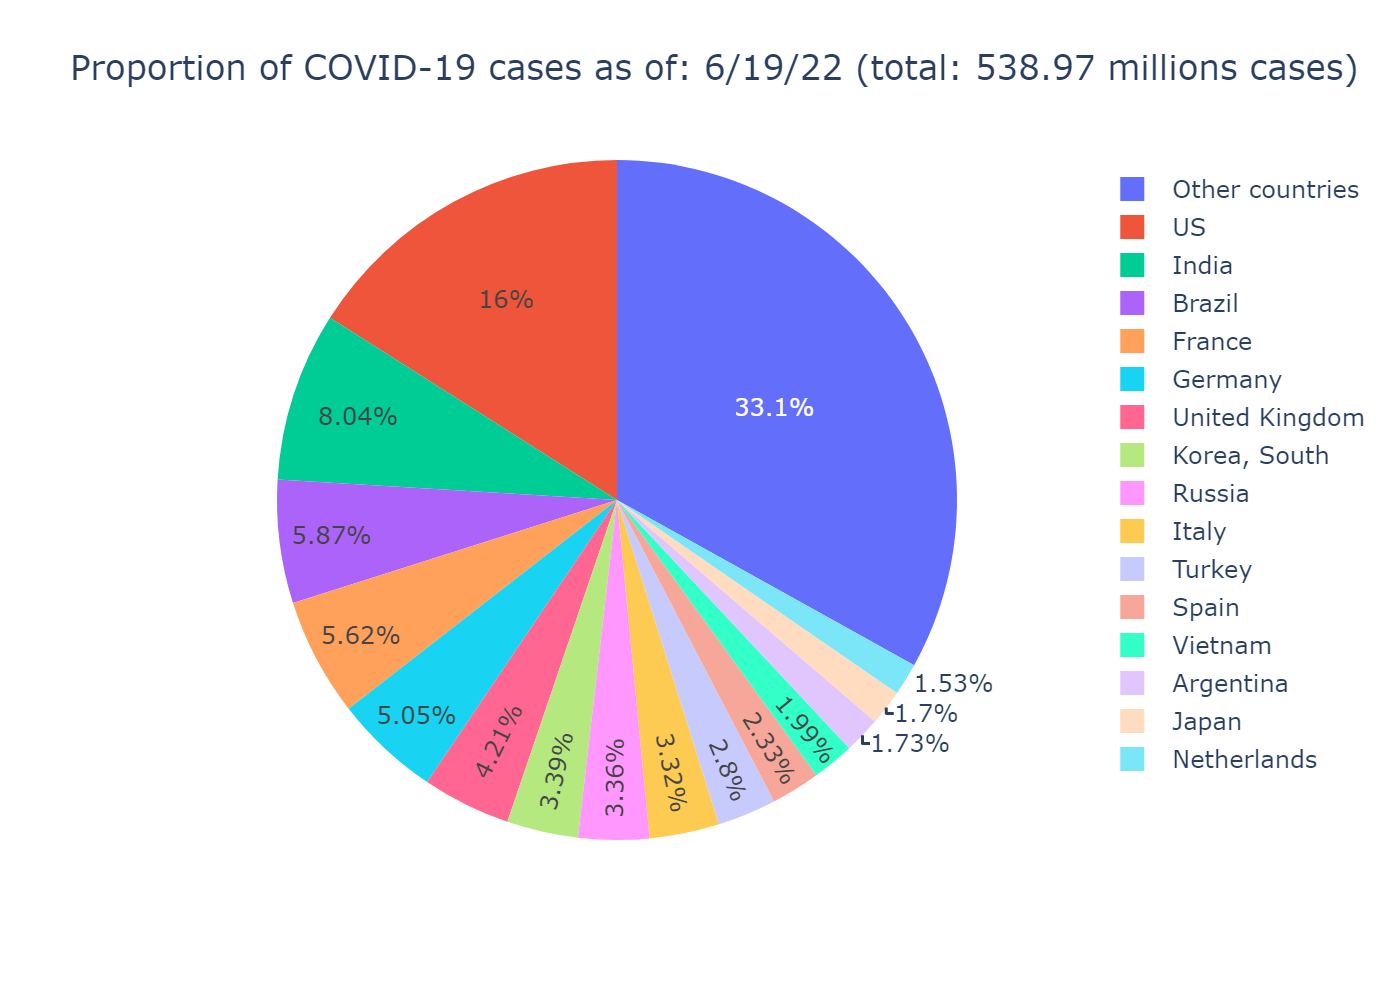

In [6]:
# Select top-15 countries and aggregate all other countries
total_case = round(global_case_collapse_country[date_string[-1]].sum() / 1000000, 2)
top_country = global_case_collapse_country.nlargest(15, date_string[-1])
country_collapse_bottom = global_case_collapse_country.copy()
country_collapse_bottom.loc[country_collapse_bottom[date_string[-1]] < top_country[date_string[-1]].min(),
                            'Country'] = 'Other countries'


# Pie chart
fig = px.pie(country_collapse_bottom, values=date_string[-1], names='Country',
             title='Proportion of COVID-19 cases as of: ' + date_string[-1] + " (total: " + str(total_case) + " millions cases)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

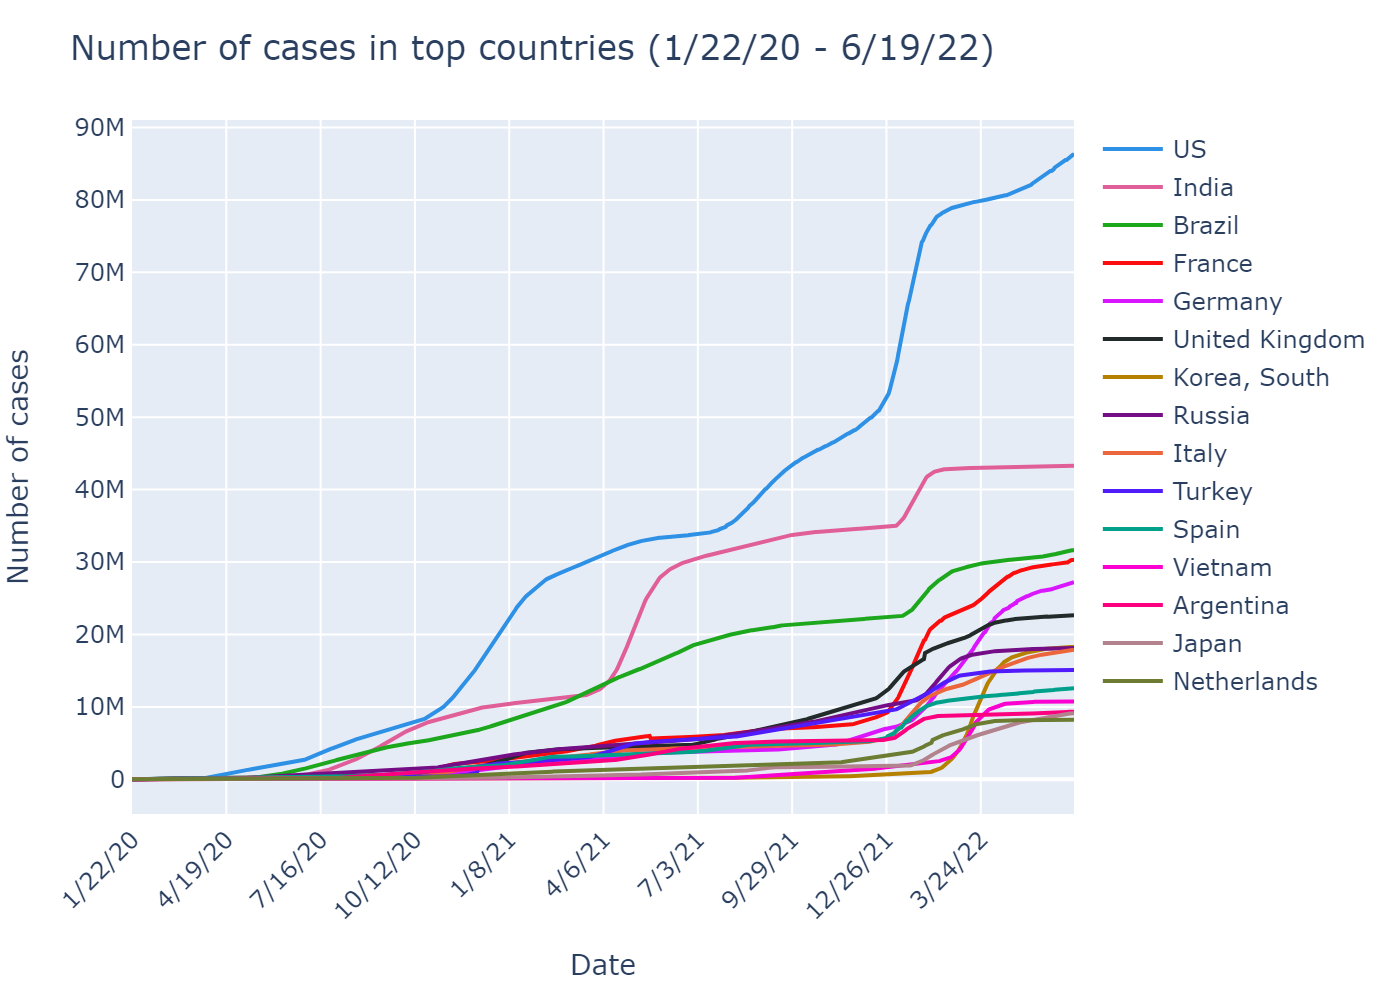

In [7]:
# Now let's look at the number of case across time for top countries
name_top_country = top_country['Country']
matrix_num_case = top_country.drop(columns=['Country', 'Lat', 'Long']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_country):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in top countries (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 countries with the least number of cases

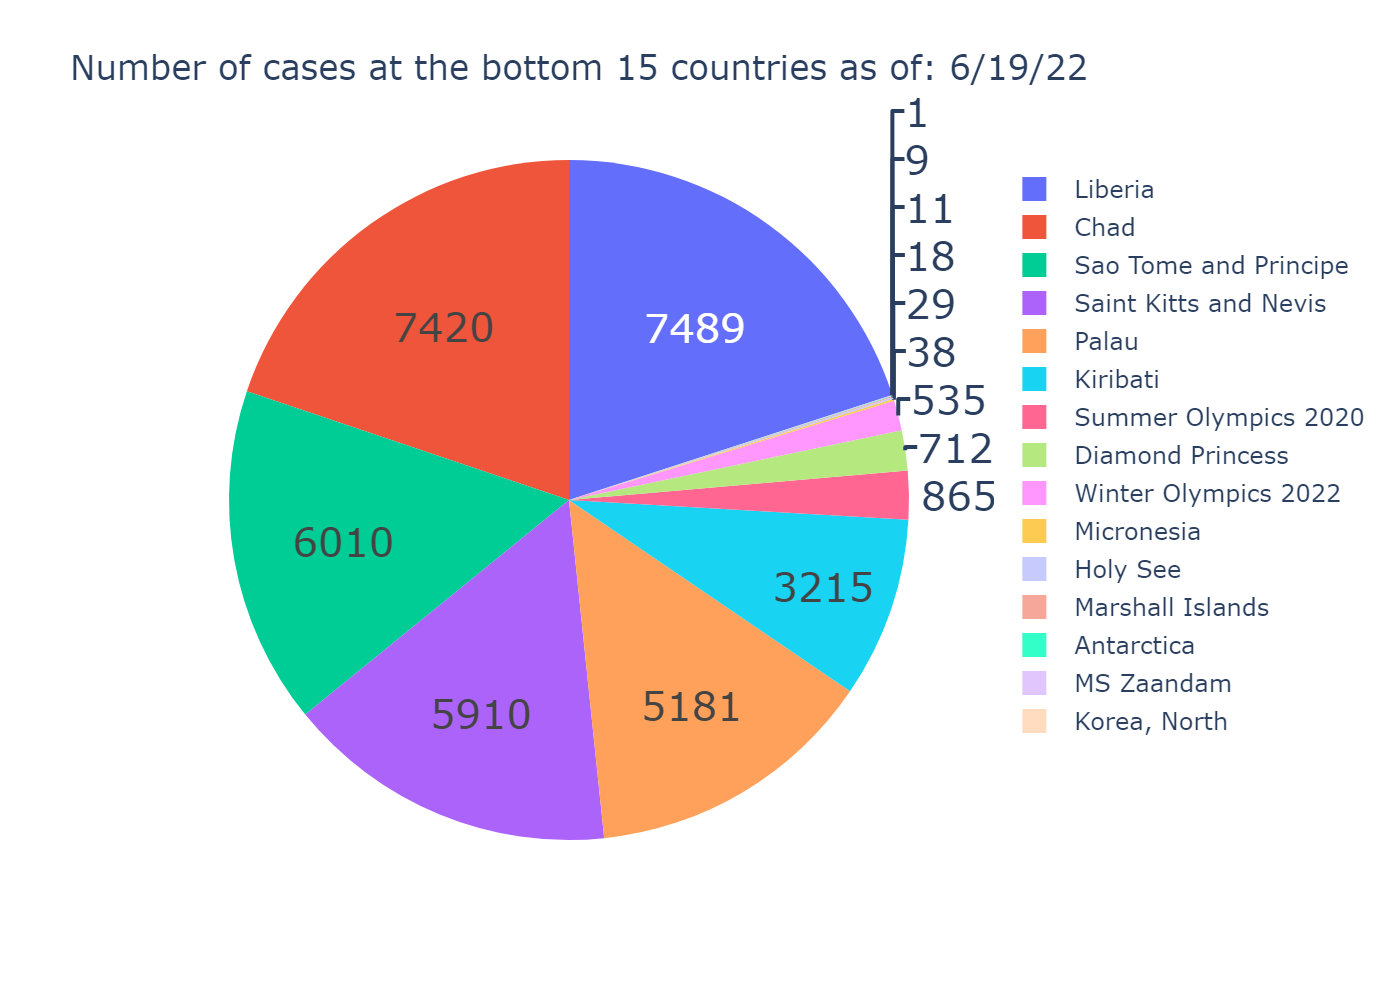

In [8]:
# Display the countries with the least number of cases
bottom_country = global_case_collapse_country.nsmallest(15, column_name[-1])
# fig = px.pie(bottom_country, values=column_name[-1], names='Country',
#              title='Proportion of COVID-19 cases at the bottom 15 countries as of: ' + column_name[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_country['Country'],
                             values=bottom_country[column_name[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size),
                 title_text='Number of cases at the bottom 15 countries as of: ' + column_name[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

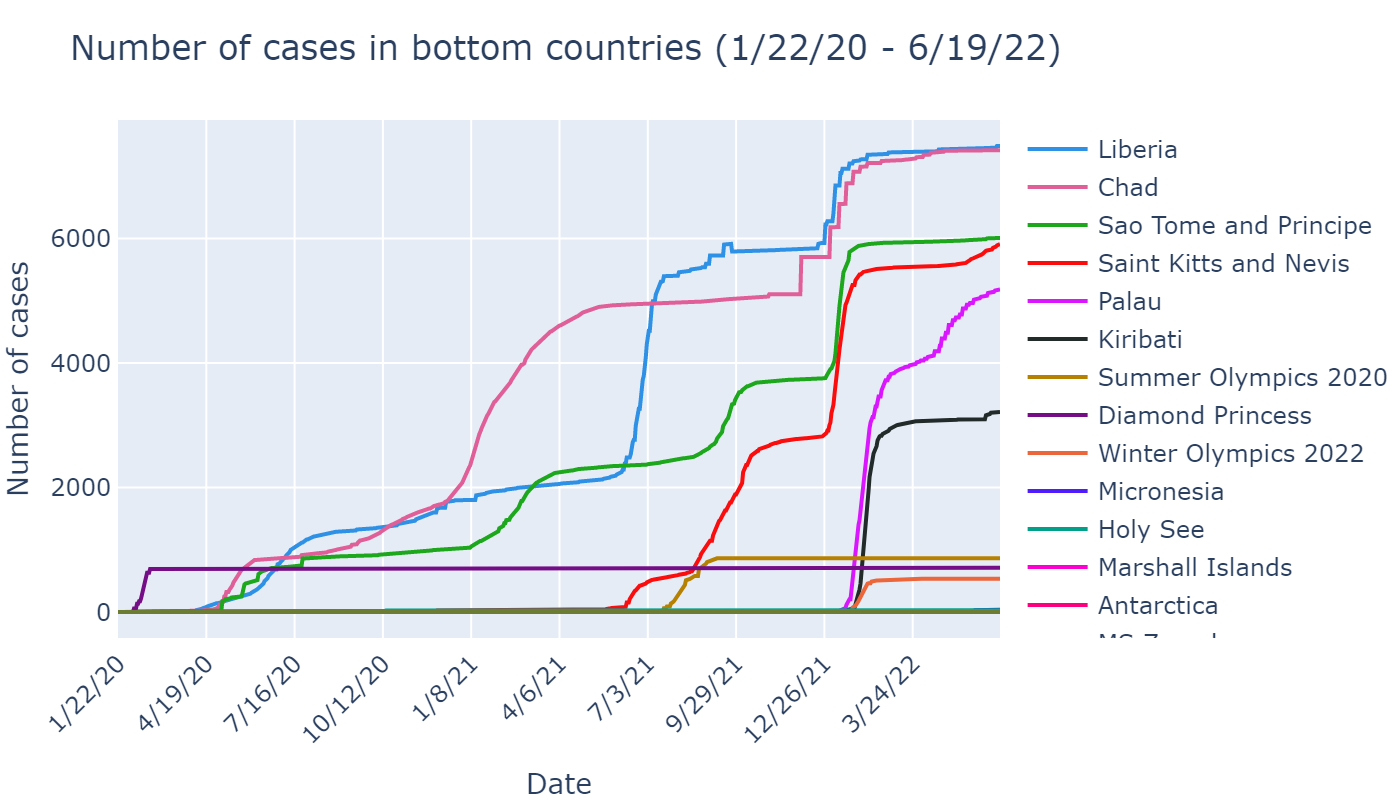

In [9]:
# Now let's look at the number of case across time for bottom countries
bottom_country.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_bottom_country = bottom_country['Country']
matrix_num_case = bottom_country.drop(columns=['Country', 'Lat', 'Long']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_bottom_country):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))

margin_size = 60
fig.update_layout(title='Number of cases in bottom countries (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=0, r=0, t=margin_size, b=margin_size), height=400)

fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

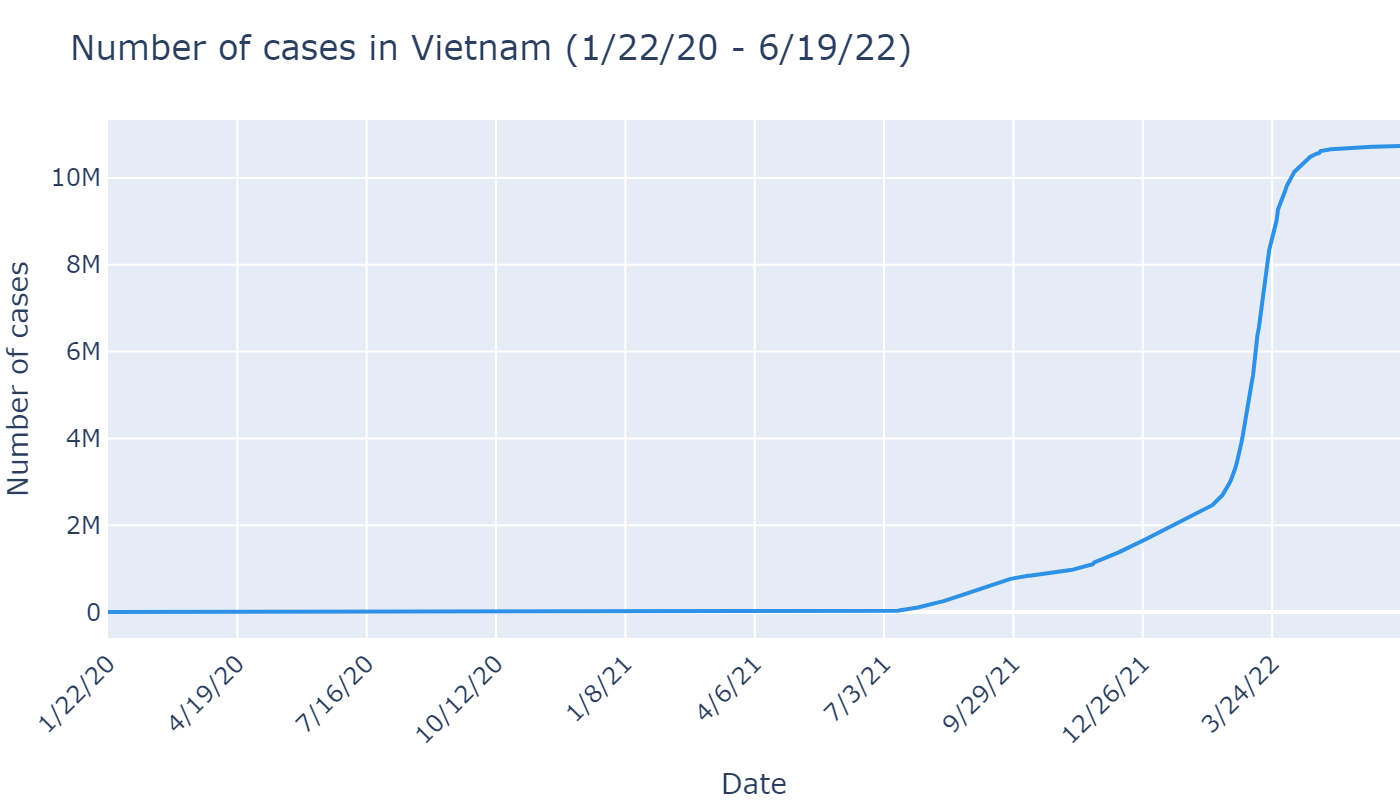

In [10]:
# Now let's look at the number of case across time for country of interest (Vietnam, in this case)
country_interest = global_case_collapse_country[global_case_collapse_country.Country=='Vietnam']
name_country_interest = country_interest['Country']
matrix_num_case = country_interest.drop(columns=['Country', 'Lat', 'Long']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_country_interest):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))

margin_size = 60
fig.update_layout(title='Number of cases in ' + name_country_interest.iloc[0] + ' (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=0, r=0, t=margin_size, b=margin_size), height=400)

fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Something more fancy: number of cases on world map

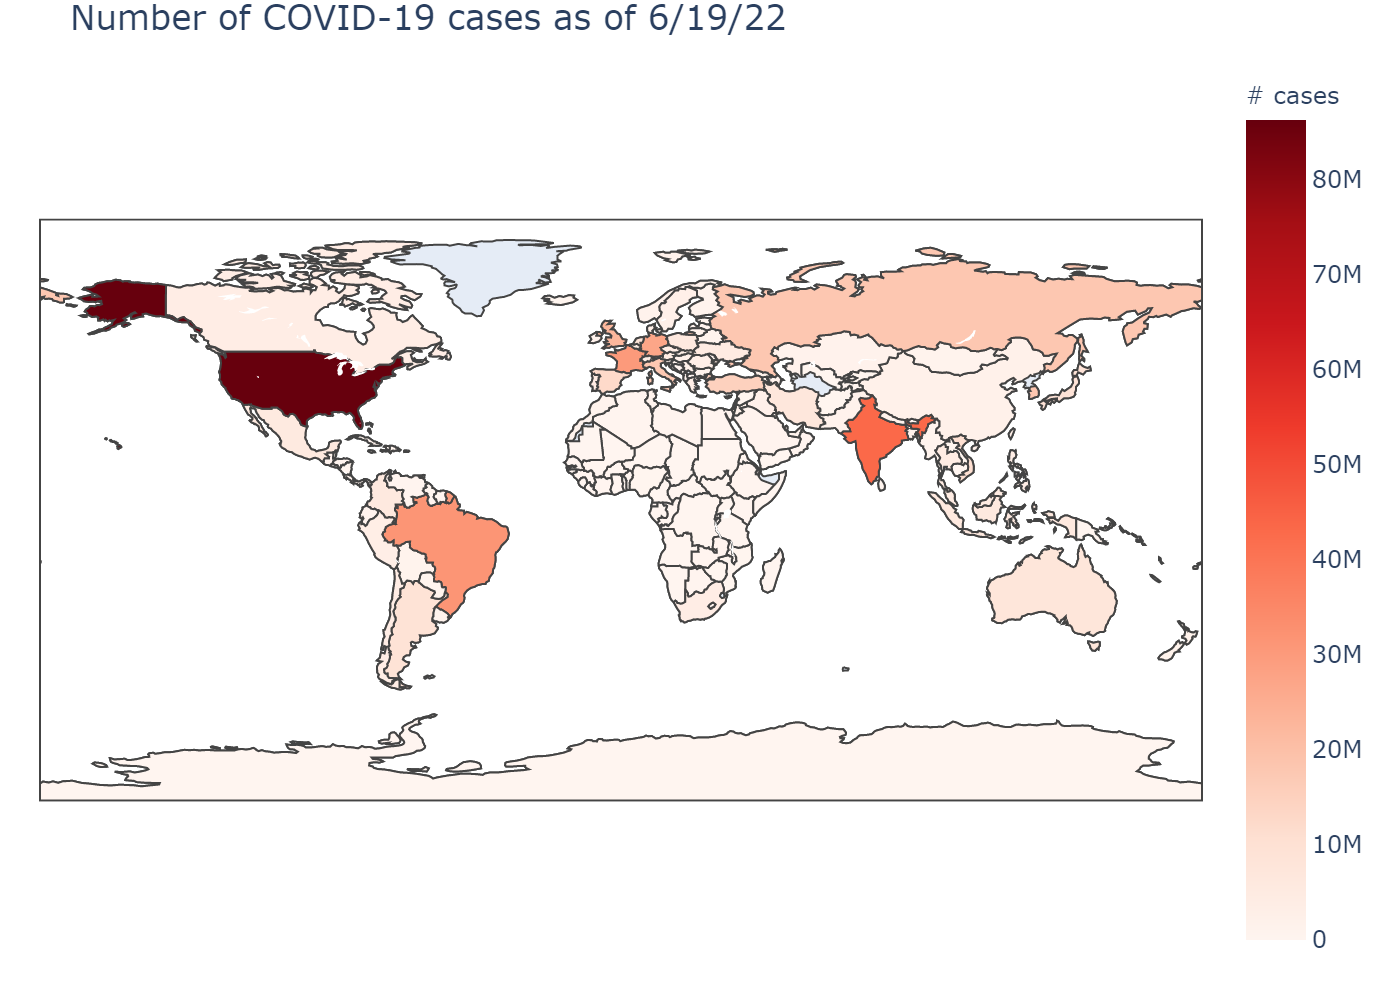

In [11]:
# Use plotly Choropleth built-in map
fig = go.Figure(data=go.Choropleth(
    locations=global_case_collapse_country["Country"], # Country names
    locationmode = 'country names', # set the mode to country name
    z = global_case_collapse_country[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

### It seems like US is a big outlier (American exceptionalism!) so we effectively cannot see any other country. So let's try to exclude US and see the world map again.

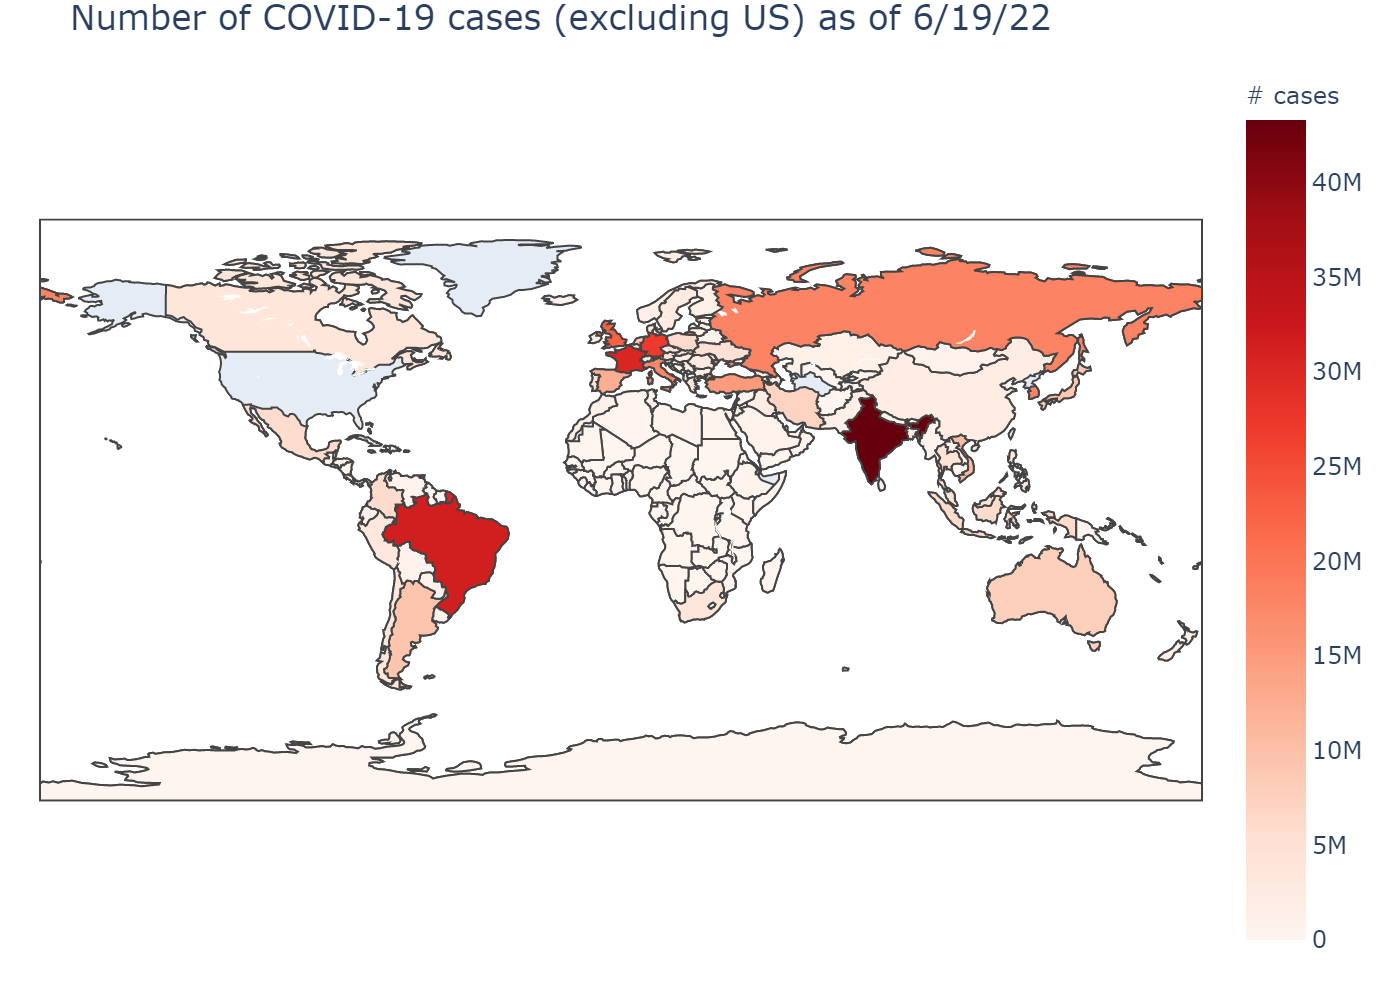

In [12]:
# Exclude US
global_case_collapse_country_excludeUS = global_case_collapse_country[global_case_collapse_country.Country != 'US']

fig = go.Figure(data=go.Choropleth(
    locations=global_case_collapse_country_excludeUS["Country"], # Country names
    locationmode = 'country names', # set the mode to country name
    z = global_case_collapse_country_excludeUS[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases (excluding US) as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Explore relation between number of cases and geographical location

### Latitude and Longitude

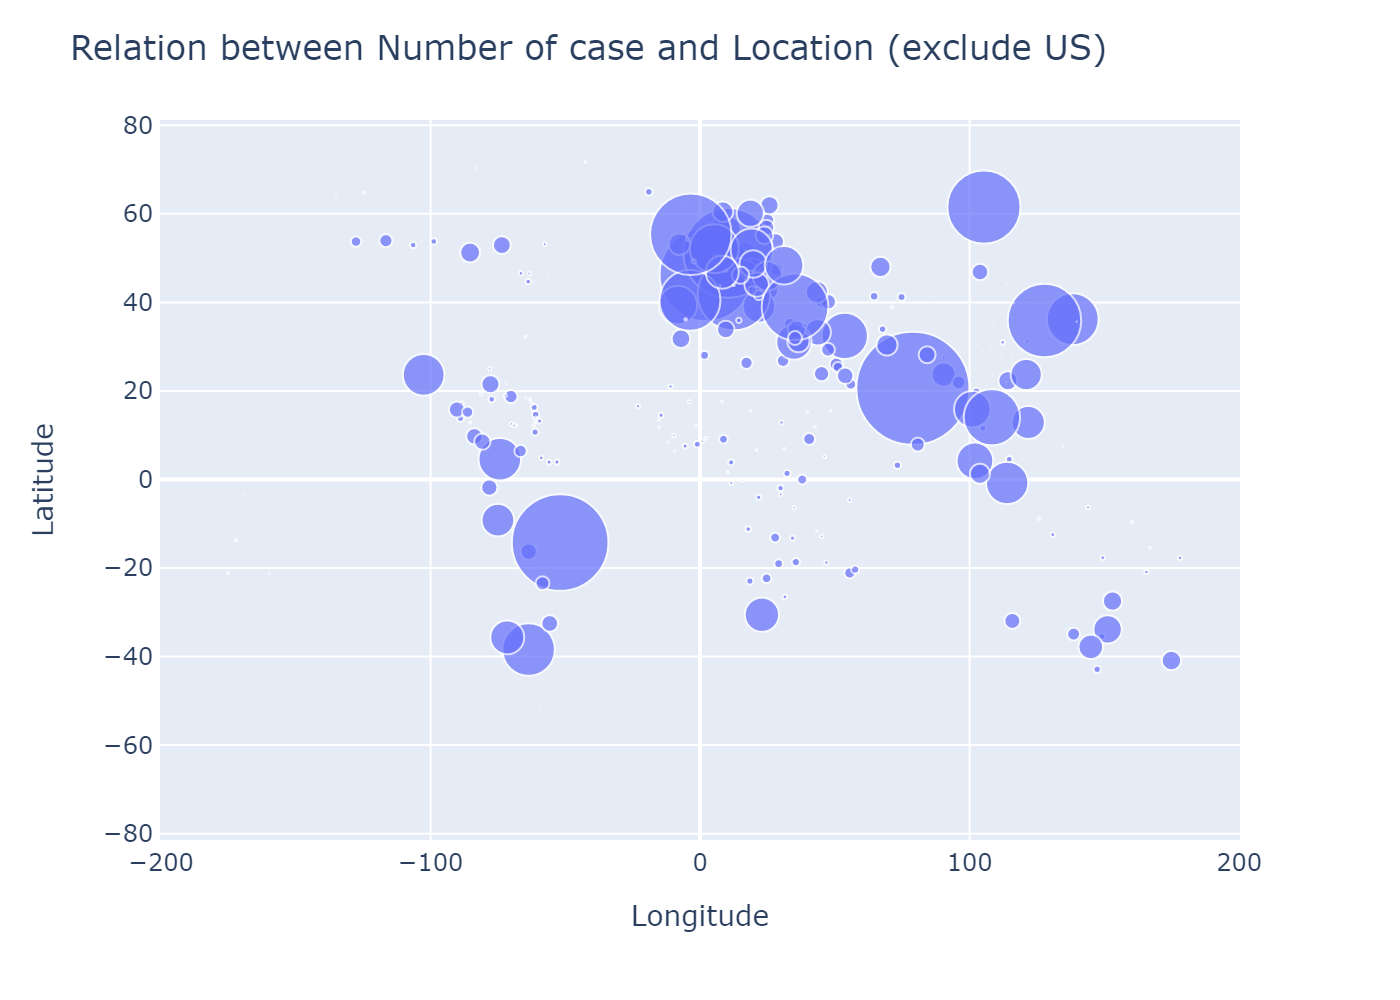

In [13]:
# Let's try bubble plot. It's similar to the world map above but instead of heatmap, 
# we use bubble size to indicate number of cases. Also note that here we use province/region
# instead of country so the location is more fine-grained (esp. for big countries like China)
fig = px.scatter(global_case[global_case.Country != 'US'], x="Long", y="Lat",
                 size=date_string[-1], hover_name="Country", size_max=40)

fig.update_layout(
    title='Relation between Number of case and Location (exclude US)',
    xaxis=dict(title='Longitude'),
    yaxis=dict(title='Latitude')
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

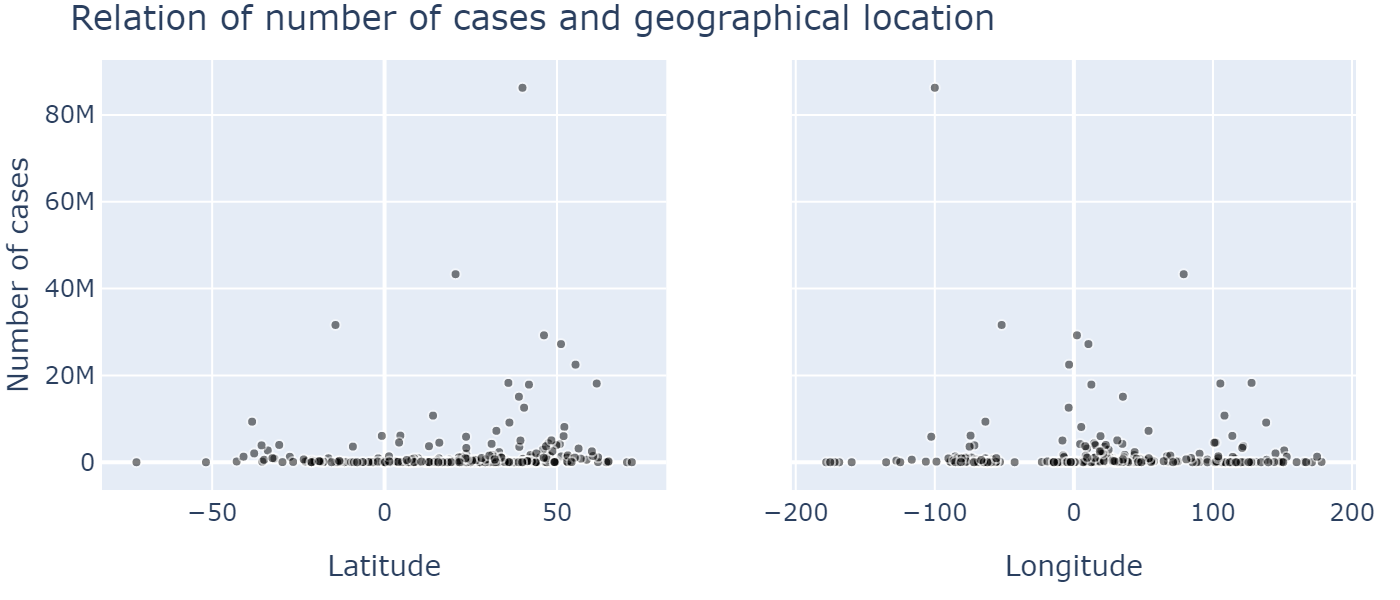

In [14]:
# Now let's split latitude and longitude
matrix_num_case = global_case.drop(columns=['Country', 'Province/State']).to_numpy()

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, 0], y=matrix_num_case[:, -1], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, 1], y=matrix_num_case[:, -1], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=2)              

fig.update_xaxes(title_text="Latitude", row=1, col=1)
fig.update_yaxes(title_text="Number of cases", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Longitude", row=1, col=2)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=300, showlegend=False,
                 title_text="Relation of number of cases and geographical location")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

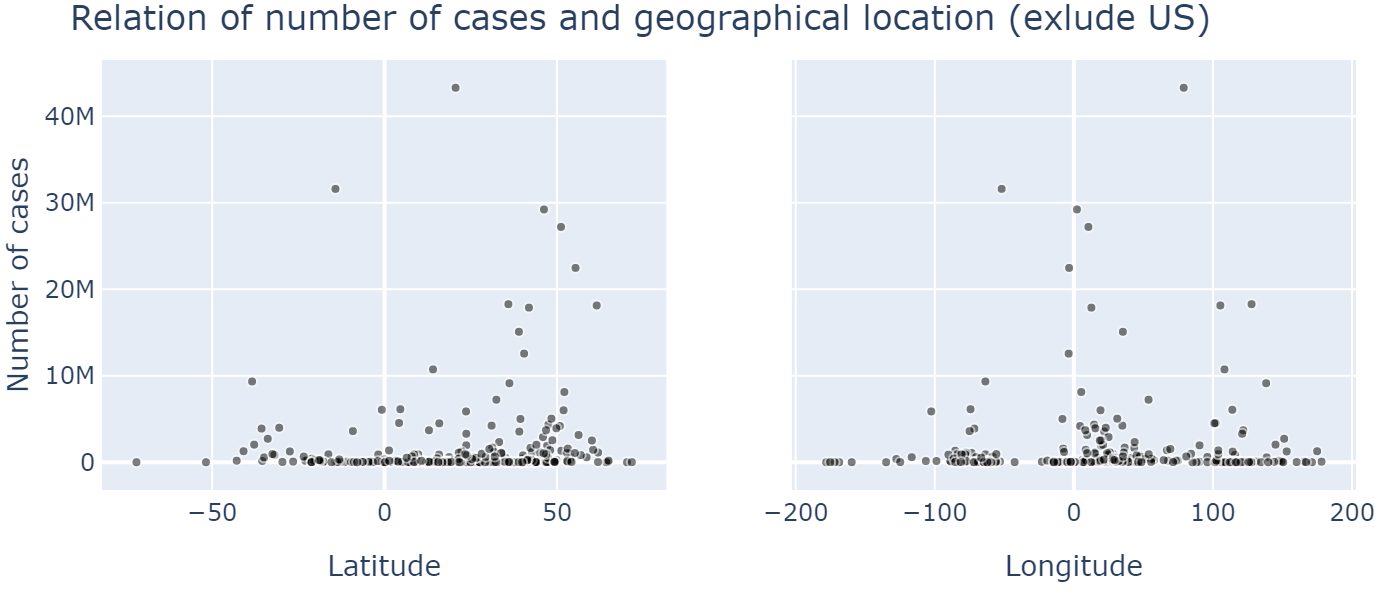

In [15]:
# Again, US is such a big outlier that we cannot see anything else
# Let's remove that big guy to look at the rest
global_case_dropUS = global_case[global_case['Country'] != 'US']
matrix_num_case = global_case_dropUS.drop(columns=['Country', 'Province/State']).to_numpy()

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, 0], y=matrix_num_case[:, -1], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, 1], y=matrix_num_case[:, -1], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1))),
              row=1, col=2)              

fig.update_xaxes(title_text="Latitude", row=1, col=1)
fig.update_yaxes(title_text="Number of cases", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Longitude", row=1, col=2)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=300, showlegend=False,
                 title_text="Relation of number of cases and geographical location (exlude US)")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

**After removing US, it seems there are weak relations between latitude/longitude and number of cases. For latitude, countries that are higher up (larger latitude) tend to have more cases. For longitude, the high number of cases tend to cluster around 0, which is UK. So it seems like most cases are at European, developed countries.**

# Use external data (GDP/Population) about countries
Because we only have geographical location of countries for current dataset, we have to get external data for more features. Here I try population and GDP dataset from World Bank: https://data.worldbank.org/

In [16]:
# Load data
print('Beginning data loading ...')

# Data directory
dir_data = os.path.join(os.getcwd(), 'data')

# GDP
dir_GDP = os.path.join(dir_data, 'GDP_2018.csv')
GDP = pd.read_csv(dir_GDP)

# Population
dir_population = os.path.join(dir_data, 'Population_2018.csv')
population = pd.read_csv(dir_population)
    
print('Data loading finished!')

Beginning data loading ...
Data loading finished!


In [17]:
# Explore the data
GDP.head(n=2)

Country Name Country Code     Indicator Name  Indicator Code         1960  \
0        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD          NaN   
1  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  537777811.1   

          1961         1962         1963         1964          1965  ...  \
0          NaN          NaN          NaN          NaN           NaN  ...   
1  548888895.6  546666677.8  751111191.1  800000044.4  1.006667e+09  ...   

           2010          2011          2012          2013          2014  \
0  2.390503e+09  2.549721e+09  2.534637e+09  2.581564e+09  2.649721e+09   
1  1.585657e+10  1.780428e+10  2.000162e+10  2.056105e+10  2.048487e+10   

           2015          2016          2017          2018  2019  
0  2.691620e+09  2.646927e+09  2.700559e+09           NaN   NaN  
1  1.990711e+10  1.936264e+10  2.019176e+10  1.936297e+10   NaN  

[2 rows x 64 columns]

In [18]:
population.head(n=2)

Country Name Country Code     Indicator Name Indicator Code       1960  \
0        Aruba          ABW  Population, total    SP.POP.TOTL    54211.0   
1  Afghanistan          AFG  Population, total    SP.POP.TOTL  8996973.0   

        1961       1962       1963       1964       1965  ...        2010  \
0    55438.0    56225.0    56695.0    57032.0    57360.0  ...    101669.0   
1  9169410.0  9351441.0  9543205.0  9744781.0  9956320.0  ...  29185507.0   

         2011        2012        2013        2014        2015        2016  \
0    102046.0    102560.0    103159.0    103774.0    104341.0    104872.0   
1  30117413.0  31161376.0  32269589.0  33370794.0  34413603.0  35383128.0   

         2017        2018  2019  
0    105366.0    105845.0   NaN  
1  36296400.0  37172386.0   NaN  

[2 rows x 64 columns]

## Cleaning the data
The big problem is that some countries' names in COVID-19 data do not match those in GDP/Population data (e.g. 'US' in COVID-19 is 'United States' in GDP/Population).

So first I find the countries in GDP/Population that are not in COVID-19 using this code:

<pre><code> GDP_not_in_list = GDP[~GDP['Country Name'].isin(unique_country_name)]
list(GDP_not_in_list['Country Name']) </code></pre>

Note that some names in the list are not even countries but some groups (e.g. 'World', 'East Asia & Pacific').

Then I cross-checked each one in that list with the country list of COVID-19 and if I found a plausible match, I put that pairs into 2 lists 'replace_old' and 'replace_new'.

Using the list, I replace the country's names in GDP/Population table to match the names of COVID-19 data.

Finally, I select only countries in GDP/Population that match COVID-19 data.

In [19]:
# List of the same non-match countries
replace_old = ['Bahamas, The',
              'Brunei Darussalam',
              'Congo, Dem. Rep.',
               'Congo, Rep.',
               'Czech Republic',
               'Egypt, Arab Rep.',
               'Gambia, The', 
               'Iran, Islamic Rep.',
               'Kyrgyz Republic',
               'St. Kitts and Nevis',
               'Korea, Rep.',
               'Lao PDR',
               'St. Lucia',
               'Myanmar',
               'Russian Federation',
               'Slovak Republic',
               'Syrian Arab Republic',
               'United States',
               'St. Vincent and the Grenadines',
               'Venezuela, RB',
               'Yemen, Rep.'
              ]
replace_new = ['Bahamas',
              'Brunei',
              'Congo (Kinshasa)',
              'Congo (Brazzaville)',
              'Czechia',
              'Egypt',
              'Gambia',
              'Iran',
              'Kyrgyzstan',
              'Saint Kitts and Nevis',
              'Korea, South',
              'Laos',
              'Saint Lucia',
              'Burma',
              'Russia',
              'Slovakia',
              'Syria',
              'US',
              'Saint Vincent and the Grenadines',
              'Venezuela',
              'Yemen']

# Replace the name to match COVID-19 data
GDP.replace(replace_old, replace_new, inplace=True)
population.replace(replace_old, replace_new, inplace=True)

In [20]:
# Select only countries that match COVID-19 data
country_COVID = unique_country_name
GDP = GDP[GDP['Country Name'].isin(country_COVID)]
population = population[population['Country Name'].isin(country_COVID)]

In [21]:
# Drop some columns that are not useful
GDP.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', '2019'], inplace=True)
population.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', '2019'], inplace=True)

# Rename feature Country Name to Country to avoid headache later
GDP.rename(columns={'Country Name': 'Country_GDP'}, inplace=True)
population.rename(columns={'Country Name': 'Country_Population'}, inplace=True)

### Now, we are gonna use only 2018 data. However, not all countries have data in 2018 so let's fill in with the latest available data for those countries

In [22]:
# Check for missing values
n_na_GDP = list(np.sum(GDP[['2018']].isna()==True))
n_na_population = list(np.sum(population[['2018']].isna()==True))
print("Number of missing value in GDP 2018: " + str(n_na_GDP[0]))
print("Number of missing value in population 2018: " + str(n_na_population[0]))

Number of missing value in GDP 2018: 7
Number of missing value in population 2018: 1


In [23]:
# Replace NaN in GDP 
temp_df = GDP.loc[GDP['2018'].isna(), '1960':'2018'].fillna(method='ffill', axis = 'columns')
GDP.loc[GDP['2018'].isna(), '2018'] = temp_df['2018']

# Replace NaN in Population 
temp_df = population.loc[population['2018'].isna(), '1960':'2018'].fillna(method='ffill', axis = 'columns')
population.loc[population['2018'].isna(), '2018'] = temp_df['2018']

## Check the cleaned data
Let's plot the GDP and population on the world map again to check if the data make sense and also to gain overal view of the data.

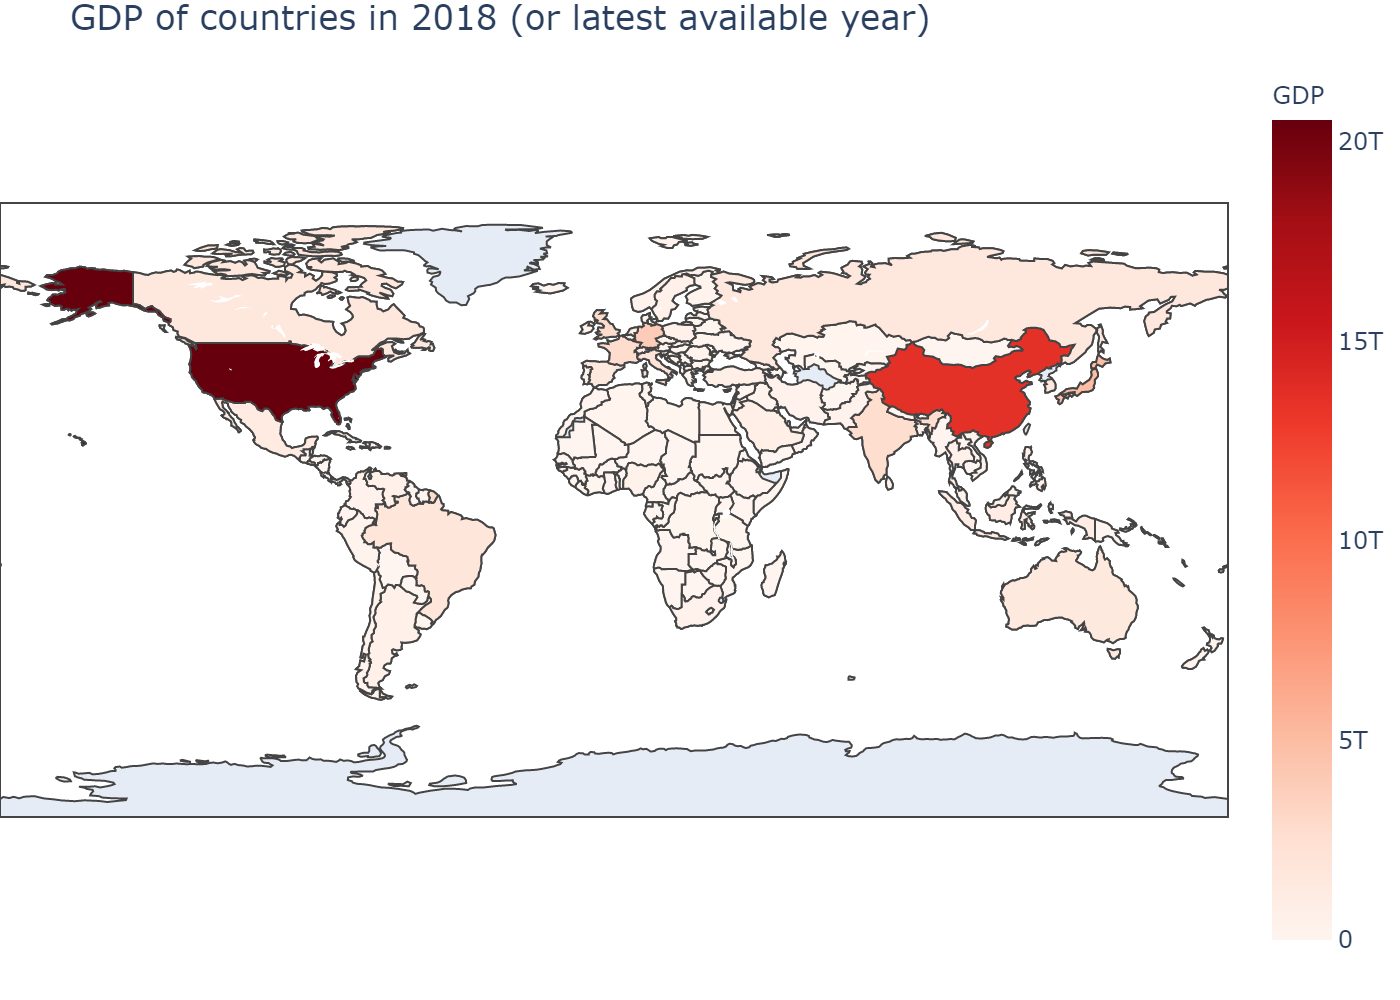

In [24]:
# First plot GDP
fig = go.Figure(data=go.Choropleth(
    locations=GDP["Country_GDP"], # Country names
    locationmode = 'country names', # set the mode to "country names"
    z = GDP["2018"].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "GDP",
))

fig.update_layout(
    title_text = 'GDP of countries in 2018 (or latest available year)',
    margin=dict(l=0, r=0, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

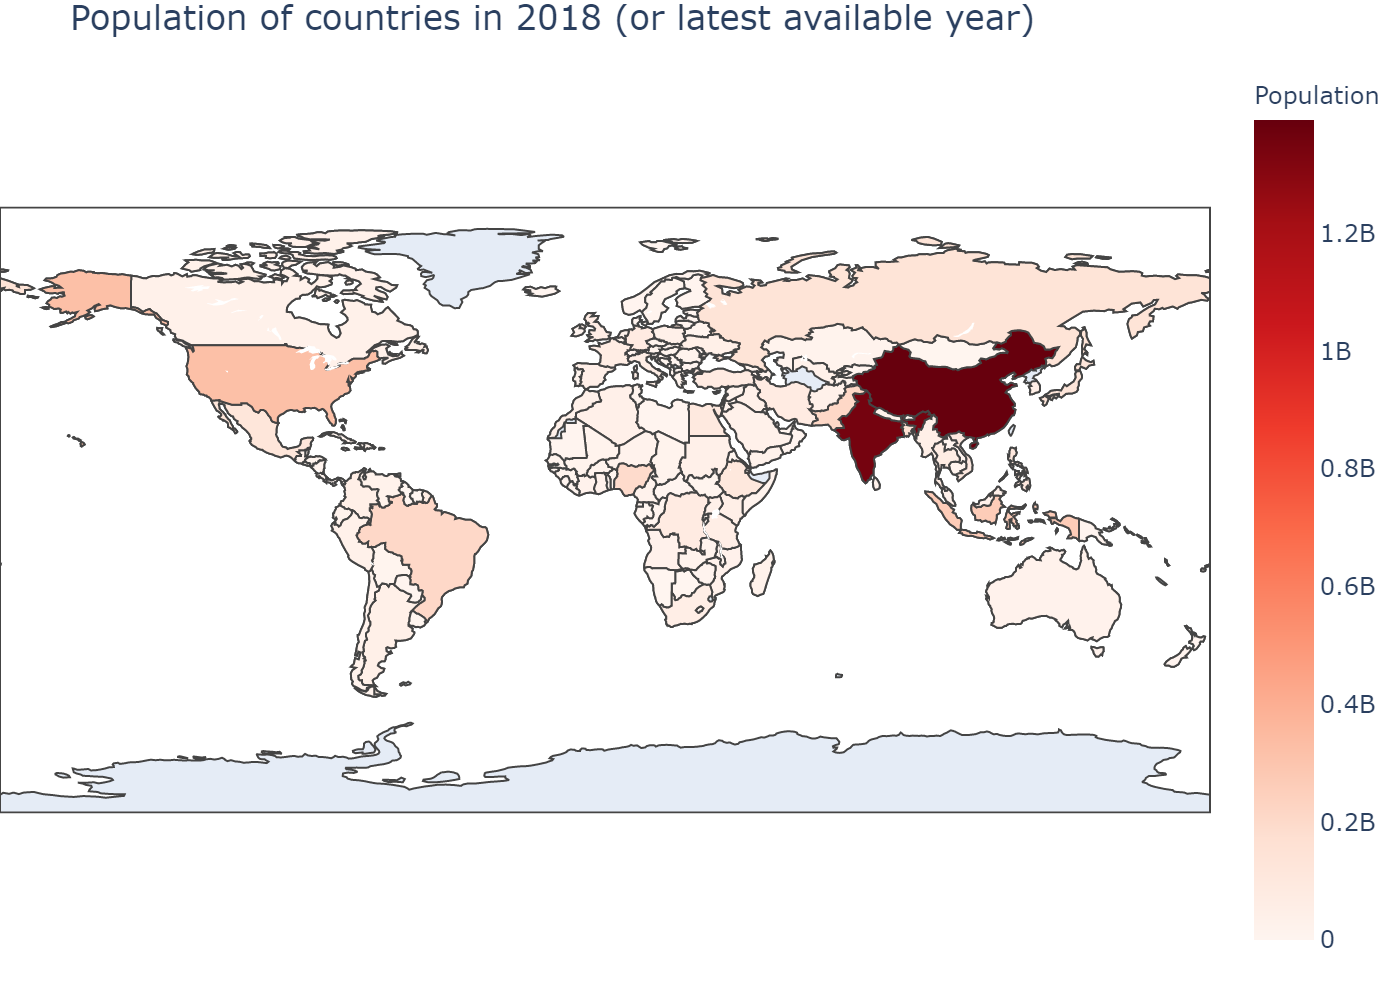

In [25]:
# Then plot population
fig = go.Figure(data=go.Choropleth(
    locations=population["Country_Population"], # Country names
    locationmode = 'country names', # set the mode to "country names"
    z = population["2018"].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "Population",
))

fig.update_layout(
    title_text = 'Population of countries in 2018 (or latest available year)',
    margin=dict(l=0, r=0, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Create a new table to merge GDP, population and COVID-19 tables
Note that some countries in COVID-19 data do not appear in GDP/population data. Again we can try to clean this up but there are only a few of them so for now let's ignore that and only take the countries existing in all datasets.

In [26]:
# Take a look at some countries that are not in GDP/population
country_missed = []
country_GDP = list(GDP['Country_GDP'])
for country in country_COVID:
    if country not in country_GDP:
        country_missed.append(country)
        
print("Countries missed in GDP/population: ", country_missed)

Countries missed in GDP/population:  ['Antarctica', 'Diamond Princess', 'Holy See', 'Korea, North', 'MS Zaandam', 'Micronesia', 'Summer Olympics 2020', 'Taiwan*', 'Winter Olympics 2022']


In [27]:
# Rename the last column of GDP and population before joining
GDP.rename(columns={'2018': 'GDP'}, inplace=True)
population.rename(columns={'2018': 'Population'}, inplace=True)

In [28]:
# Merge the tables
table_COVID_GDP_pop = global_case_collapse_country.merge(GDP[['Country_GDP', 'GDP']], left_on='Country', right_on='Country_GDP', how='inner')
table_COVID_GDP_pop = table_COVID_GDP_pop.merge(population[['Country_Population', 'Population']], left_on='Country', right_on='Country_Population', how='inner')

In [29]:
# Let's check
table_COVID_GDP_pop.head(2)

Country       Lat       Long  1/22/20  1/23/20  1/24/20  1/25/20  \
0  Afghanistan  33.93911  67.709953        0        0        0        0   
1      Albania  41.15330  20.168300        0        0        0        0   

   1/26/20  1/27/20  1/28/20  ...  6/14/22  6/15/22  6/16/22  6/17/22  \
0        0        0        0  ...   181178   181236   181465   181534   
1        0        0        0  ...   276821   276821   276821   277141   

   6/18/22  6/19/22  Country_GDP           GDP  Country_Population  Population  
0   181574   181666  Afghanistan  1.936297e+10         Afghanistan  37172386.0  
1   277141   277409      Albania  1.510250e+10             Albania   2866376.0  

[2 rows x 887 columns]

In [30]:
# Drop the redundant columns
table_COVID_GDP_pop.drop(columns=['Country_Population', 'Country_GDP'], inplace=True)

In [31]:
# # Sanity check, plot the GDP map again to see if our manipulation makes sense
# fig = go.Figure(data=go.Choropleth(
#     locations=table_COVID_GDP_pop["Country"], # Country names
#     locationmode = 'country names', # set the mode to "country names"
#     z = table_COVID_GDP_pop["GDP"].astype(float), # Data to be color-coded
#     colorscale = 'Reds',
#     colorbar_title = "GDP",
# ))

# fig.update_layout(
#     title_text = 'GDP of countries in 2018 (or latest available year)',
#     margin=dict(l=0, r=0, t=30, b=20)
# )

# # Interactive plot
# # fig.show()

# # Static plot (for view on Github)
# Image(pio.to_image(fig, format='png', scale=2))

## Relation between COVID-19 cases and GDP/Population

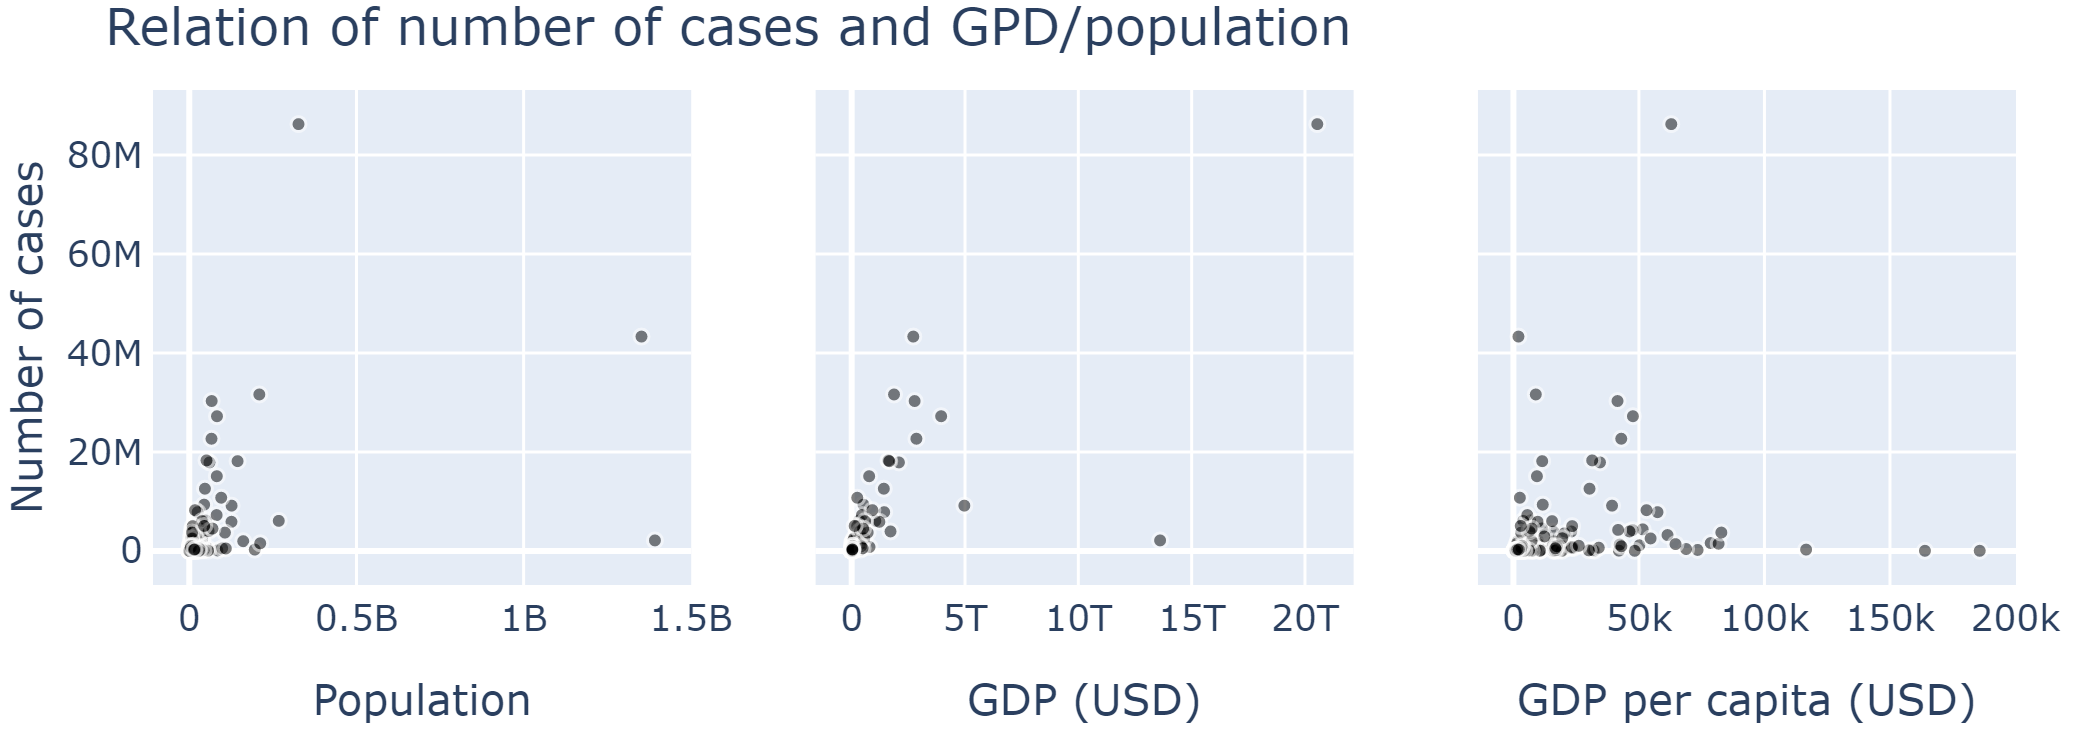

In [32]:
# Look at all countries
matrix_num_case = table_COVID_GDP_pop.drop(table_COVID_GDP_pop.iloc[:, :-3], axis=1).to_numpy()
gdp_per_captia = matrix_num_case[:, -2] / matrix_num_case[:, -1]
country_COVID_GDP_pop = list(table_COVID_GDP_pop['Country'])

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -1], y=matrix_num_case[:, -3], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_GDP_pop),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -2], y=matrix_num_case[:, -3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=2)              
fig.add_trace(go.Scatter(x=gdp_per_captia, y=matrix_num_case[:, -3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=3)  

fig.update_yaxes(title_text="Number of cases", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Population", row=1, col=1)
fig.update_xaxes(title_text="GDP (USD)", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita (USD)", row=1, col=3)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of number of cases and GPD/population")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

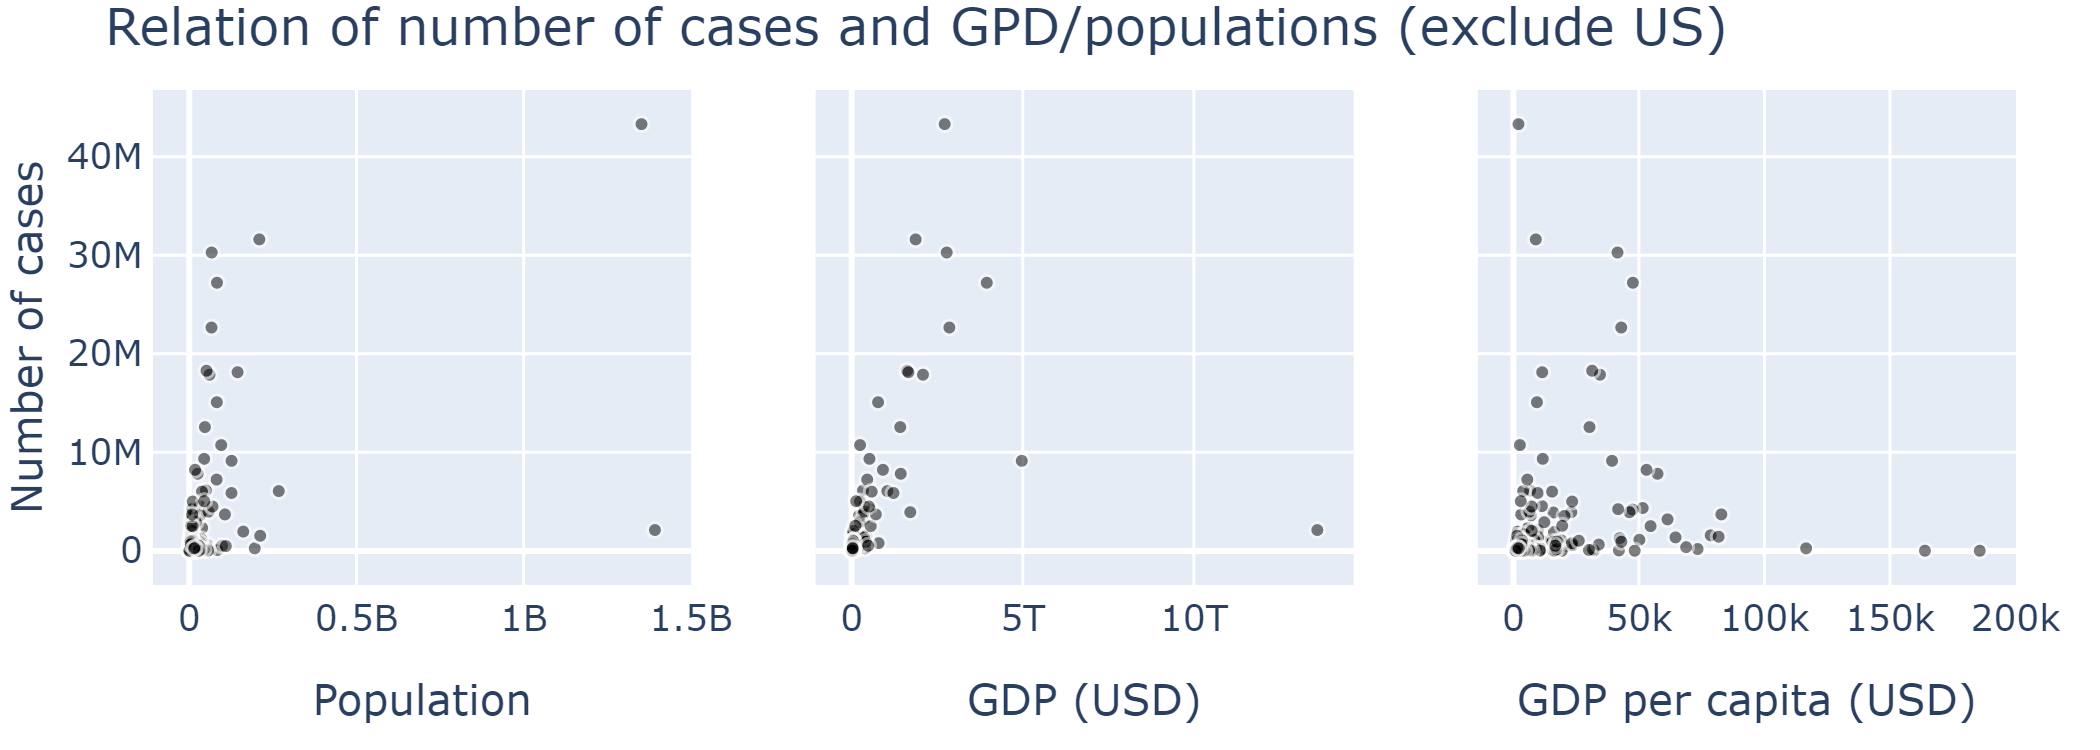

In [33]:
# Exclude US
matrix_num_case = table_COVID_GDP_pop.drop(table_COVID_GDP_pop.iloc[:, :-3], axis=1).drop(table_COVID_GDP_pop.loc[table_COVID_GDP_pop['Country']=='US'].index).to_numpy()
gdp_per_captia = matrix_num_case[:, -2] / matrix_num_case[:, -1]

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -1], y=matrix_num_case[:, -3], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_GDP_pop),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -2], y=matrix_num_case[:, -3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=2)              
fig.add_trace(go.Scatter(x=gdp_per_captia, y=matrix_num_case[:, -3], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=3)  

fig.update_yaxes(title_text="Number of cases", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Population", row=1, col=1)
fig.update_xaxes(title_text="GDP (USD)", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita (USD)", row=1, col=3)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of number of cases and GPD/populations (exclude US)")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

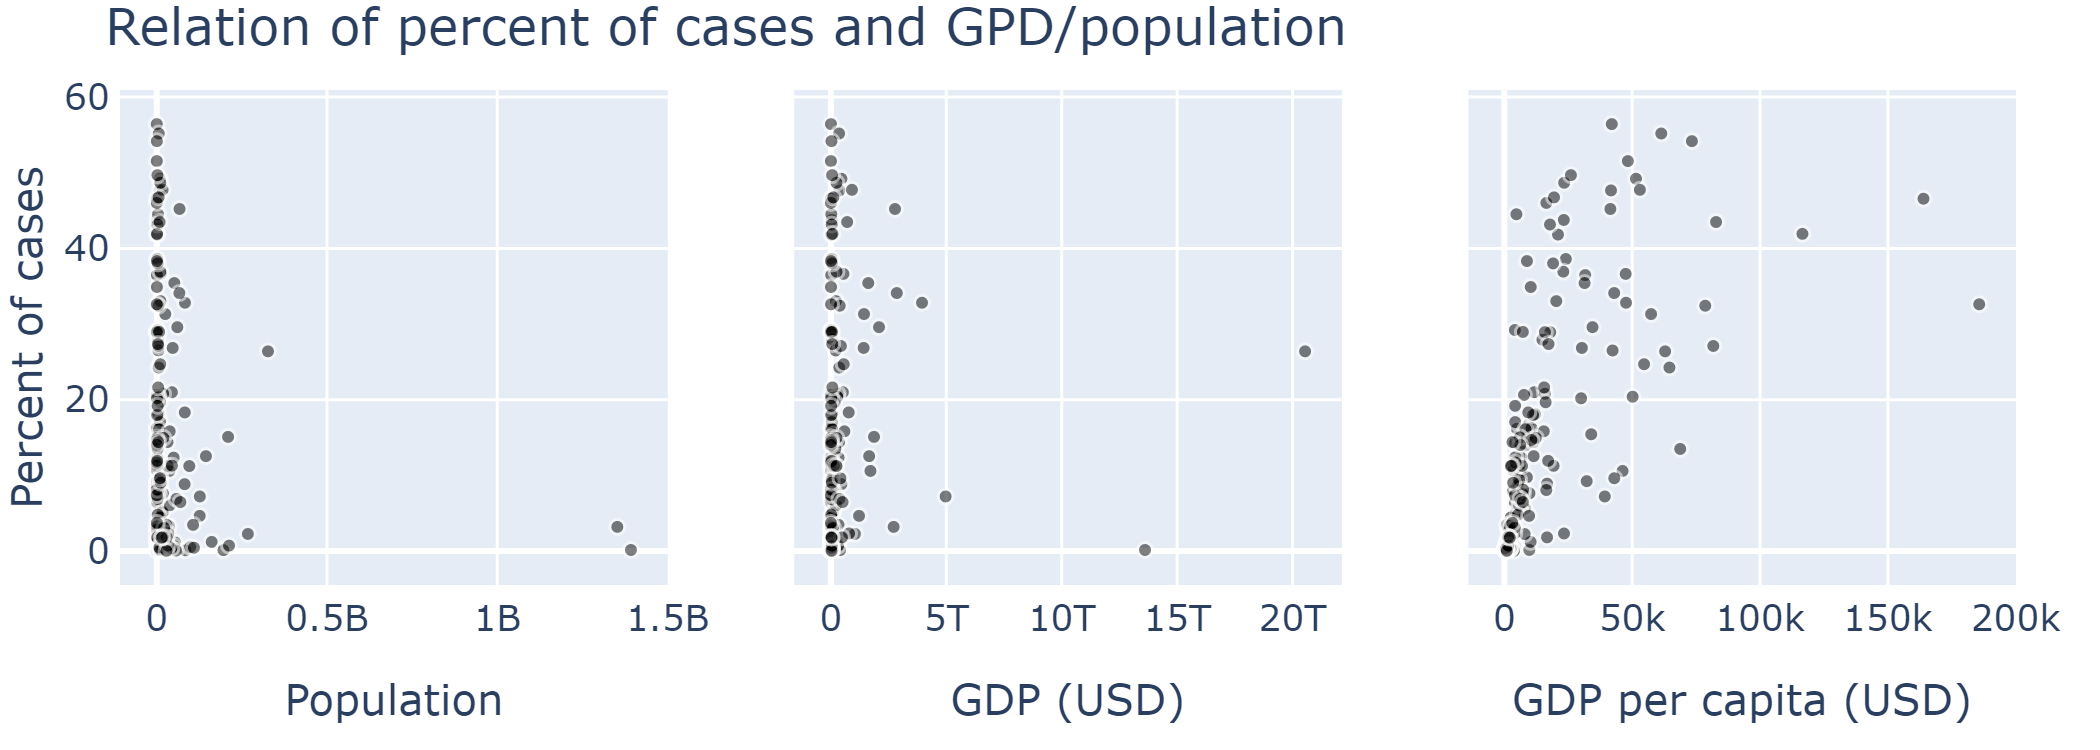

In [34]:
# Look at percent of cases instead of number of cases
matrix_num_case = table_COVID_GDP_pop.drop(table_COVID_GDP_pop.iloc[:, :-3], axis=1).to_numpy()
gdp_per_captia = matrix_num_case[:, -2] / matrix_num_case[:, -1]
percent_case = 100 * matrix_num_case[:, -3] / matrix_num_case[:, -1]

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -1], y=percent_case, mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_GDP_pop),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -2], y=percent_case, mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=2)              
fig.add_trace(go.Scatter(x=gdp_per_captia, y=percent_case, mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=3)  

fig.update_yaxes(title_text="Percent of cases", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Population", row=1, col=1)
fig.update_xaxes(title_text="GDP (USD)", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita (USD)", row=1, col=3)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of percent of cases and GPD/population")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

### First, there's some correlation between population and the number of case but that is apparently trivial (the more number of people you have, the more cases you should expect). There are 3 obvious outliers (US, China and India). For US, population does not justify the insane number of cases. For China, the data may be a bit dubious.

### Second, there is stronger correlation between GDP and number of case. Intuitively, that makes sense because the more economic activity, the more travel, which is surely the number one cause of disease transmission. However, the relation is confounded by population because GDP is the total economic output so obviously the higher population, the larger GDP. Therefore, I look at GDP per capita (GDP divided by population). Doing that reduces the correlation but there is still some trend. Note that GDP per capita is not necessarily better indicator of economic activity than GDP because there are small rich countries. For example, 3 obvious oulier countries on the right are Monaco, Liechtenstein and Luxembourg. Those countries may be rich and small but I doubt there's a lot of economic activity there.

### Finally, instead of looking at the absolute number of cases, I look at the percent of cases. That measure will remove the population size and indicates how infectious the disease is in that country. The result shows strong correlation between percent of cases and GDP per capita, which suggests that the more economic activity, the more infectious the disease is.

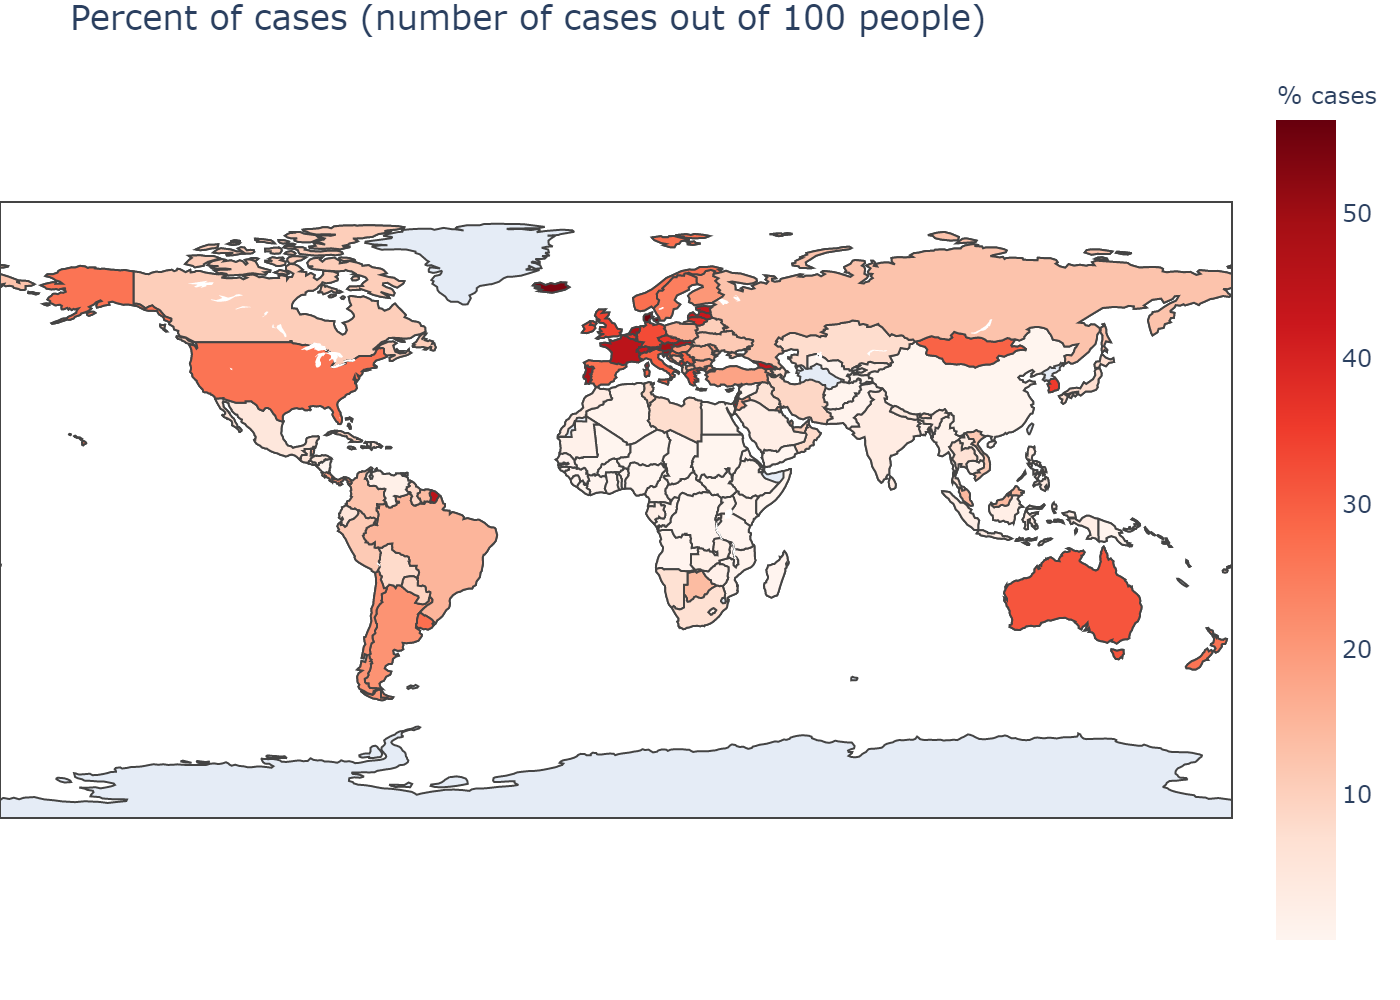

In [35]:
# Try world map for percent of cases
fig = go.Figure(data=go.Choropleth(
    locations=table_COVID_GDP_pop["Country"], # # Country names
    locationmode = 'country names', # set the mode to "country names"
    z = percent_case.astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "% cases",
))

fig.update_layout(
    title_text = 'Percent of cases (number of cases out of 100 people)',
    margin=dict(l=0, r=0, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

# Global number of deaths

## Clean up the data a bit
Here the data structure should be similar to global case.

Also, given our analysis of number of case, the death rate may be more informative than the number of death. So here we will also look at the death rate.

In [36]:
# Rename feature Country/Region to Country to avoid headache later
global_death.rename(columns={'Country/Region': 'Country'}, inplace=True)

# Collapse across countries 
global_death_collapse_country = global_death.groupby('Country').sum().reset_index()

In [37]:
# Create new table of death rate
global_death_rate = global_death.iloc[:, 2:].div(global_case.iloc[:, 2:]).mul(100)
global_death_rate.insert(0, 'Country', global_death['Country'])

global_death_rate_collapse_country = global_death_collapse_country.iloc[:, 1:].div(global_case_collapse_country.iloc[:, 1:]).mul(100)
global_death_rate_collapse_country.insert(0, 'Country', global_death_collapse_country['Country'])

## Look at the number of deaths

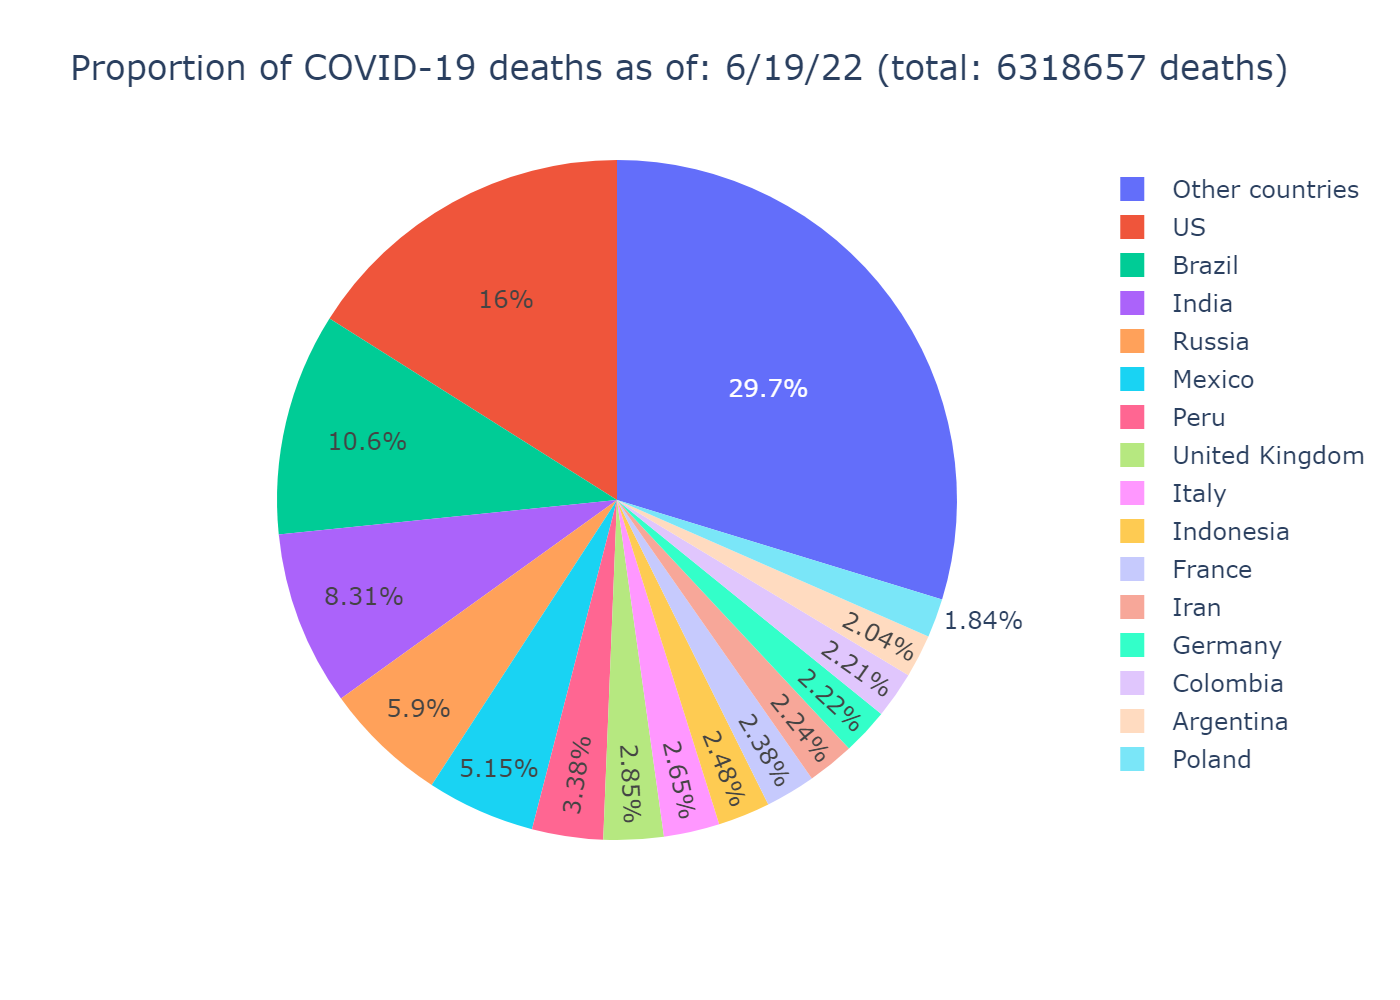

In [38]:
# First look at the number of deaths
total_case = global_death_collapse_country[date_string[-1]].sum()
top_country = global_death_collapse_country.nlargest(15, date_string[-1])
country_collapse_bottom = global_death_collapse_country.copy()
country_collapse_bottom.loc[country_collapse_bottom[date_string[-1]] < top_country[date_string[-1]].min(),
                            'Country'] = 'Other countries'


# Pie chart
fig = px.pie(country_collapse_bottom, values=date_string[-1], names='Country',
             title='Proportion of COVID-19 deaths as of: ' + date_string[-1] + " (total: " + str(total_case) + " deaths)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

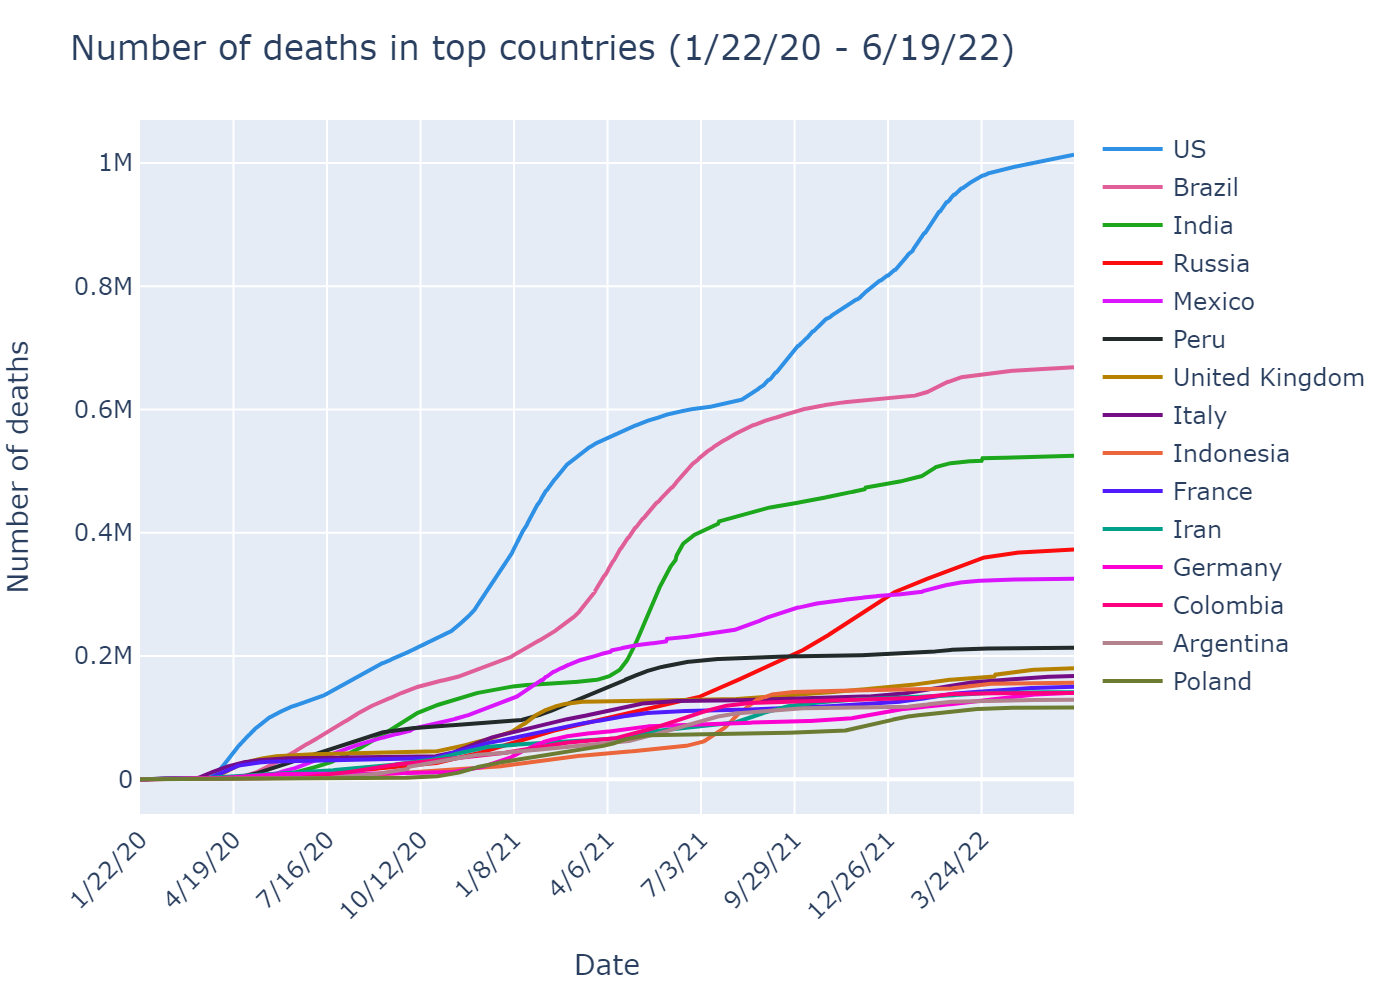

In [39]:
# Now let's look at the number of case across time for top countries
name_top_country = top_country['Country']
matrix_num_case = top_country.drop(columns=['Country', 'Lat', 'Long']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_country):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of deaths in top countries (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of deaths',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

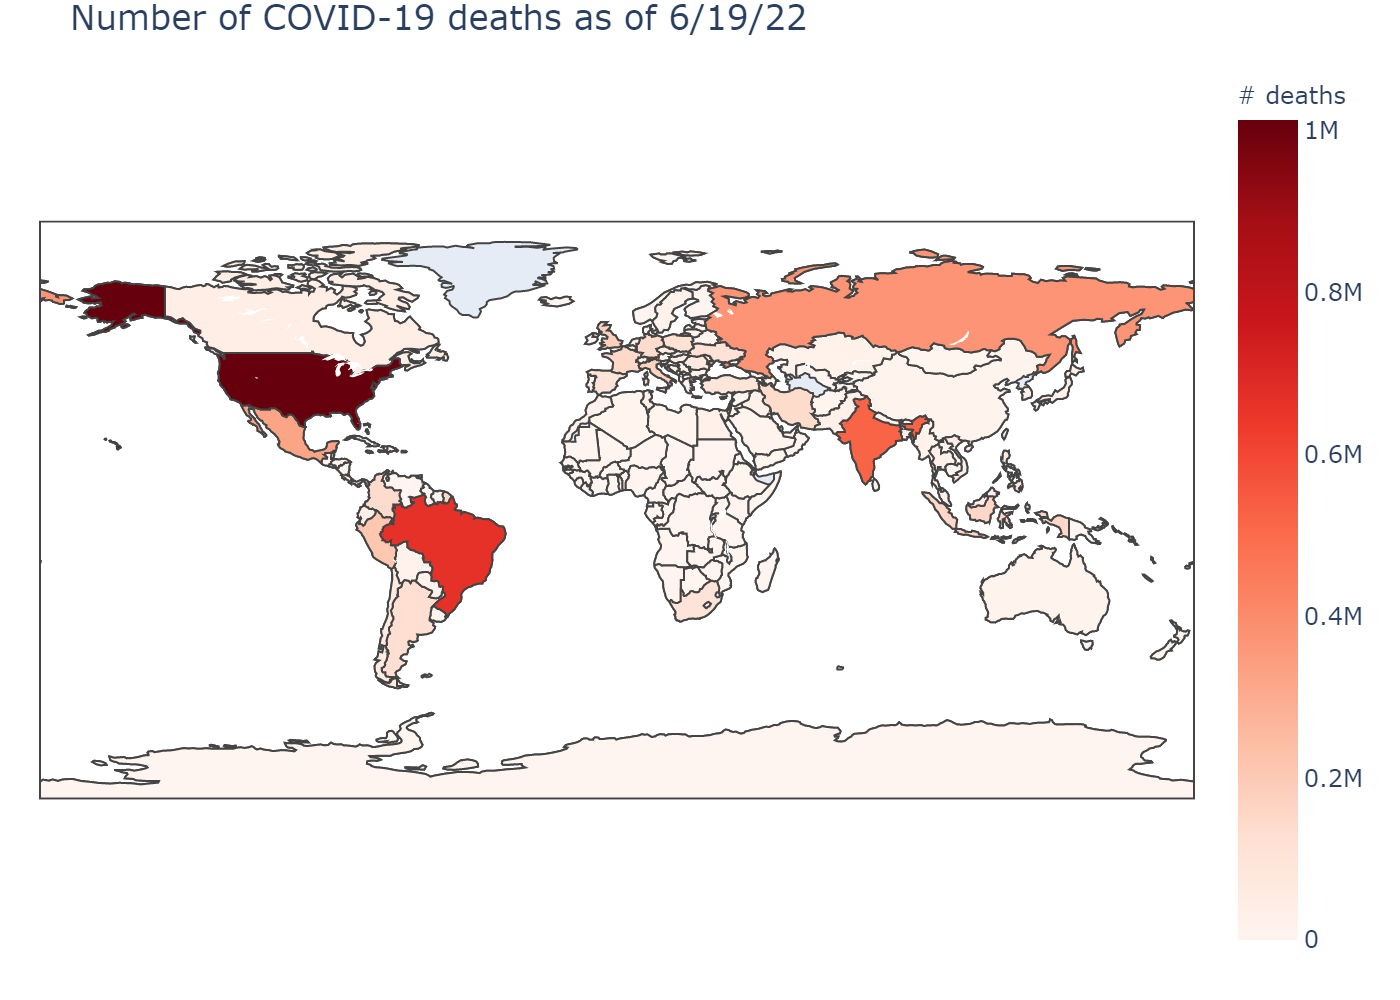

In [40]:
# Now let's see the world map
fig = go.Figure(data=go.Choropleth(
    locations=global_death_collapse_country["Country"], # Country names
    locationmode = 'country names', # set the mode to country name
    z = global_death_collapse_country[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# deaths",
))

fig.update_layout(
    title_text = 'Number of COVID-19 deaths as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

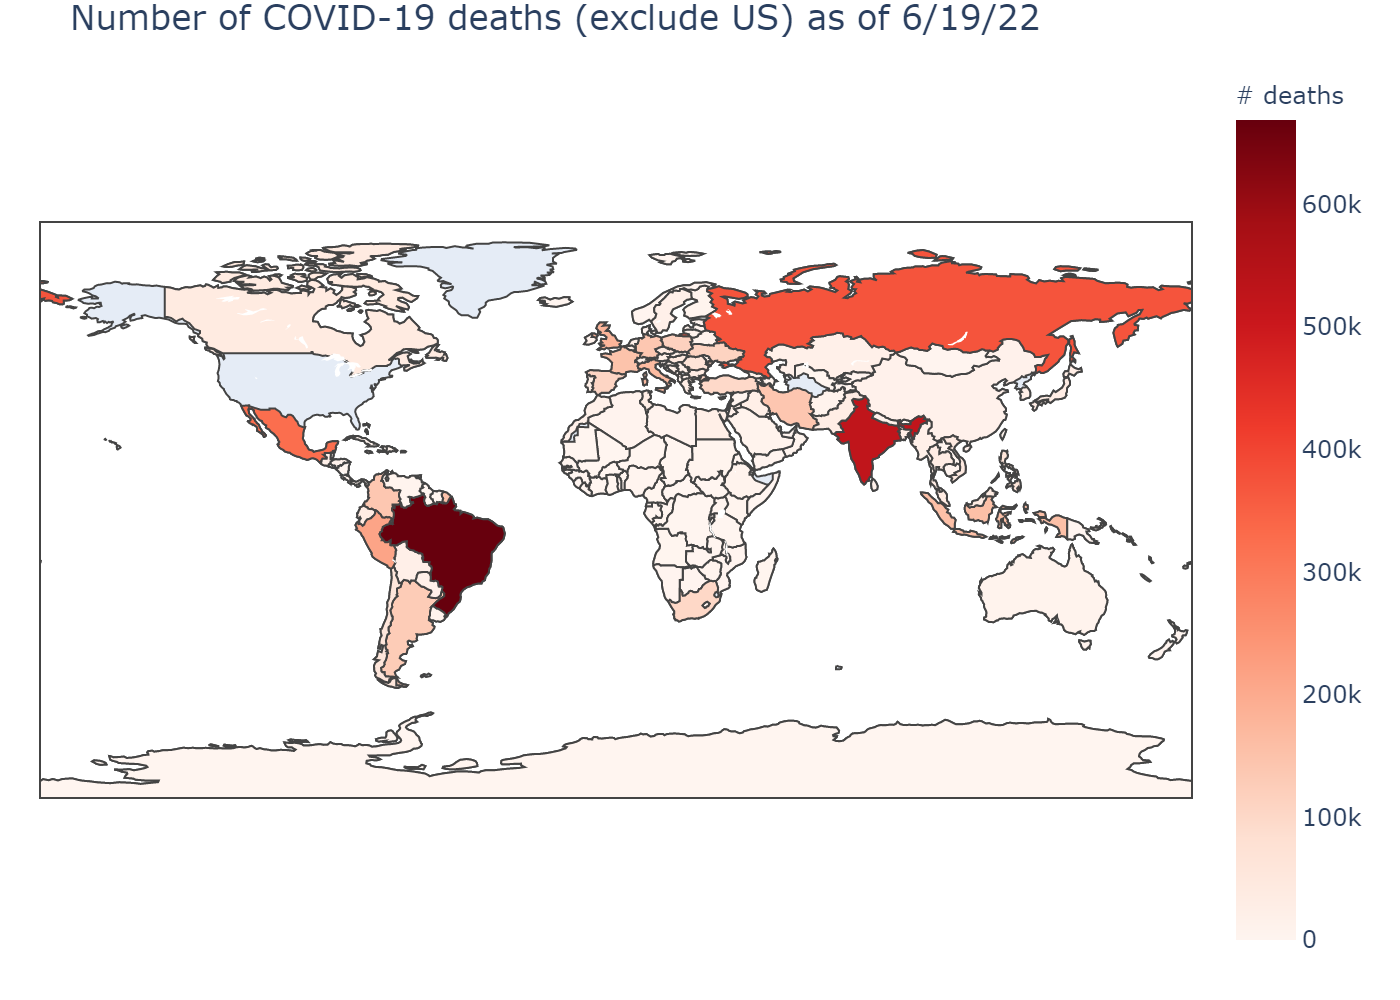

In [41]:
# Now let's see the world map (exclude US)
global_death_collapse_country_excludeUS = global_death_collapse_country[global_death_collapse_country.Country != 'US']

fig = go.Figure(data=go.Choropleth(
    locations=global_death_collapse_country_excludeUS["Country"], # Country names
    locationmode = 'country names', # set the mode to country name
    z = global_death_collapse_country_excludeUS[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# deaths",
))

fig.update_layout(
    title_text = 'Number of COVID-19 deaths (exclude US) as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at the death rates (number of death every 100 cases)

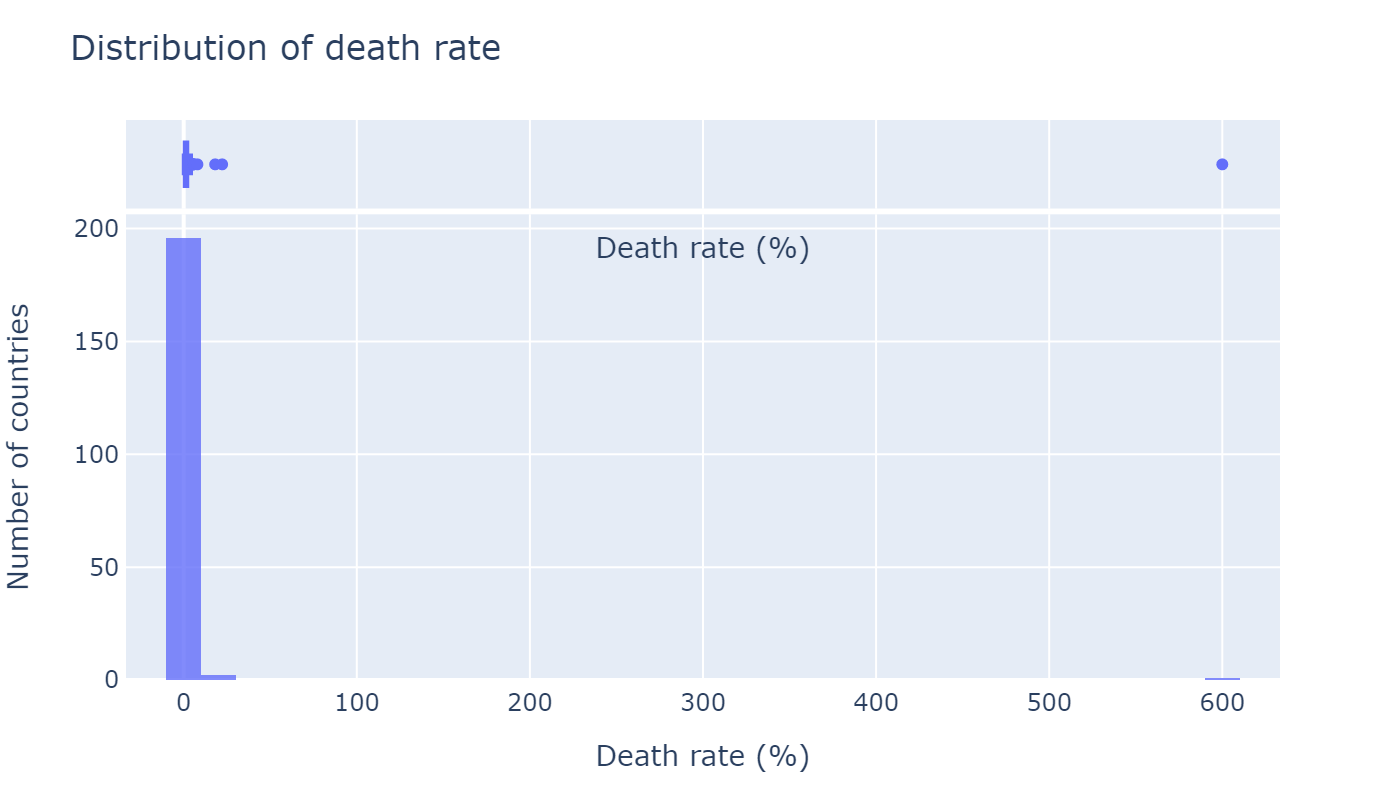

In [42]:
# Distribution of death rate
fig = px.histogram(global_death_rate_collapse_country, x=date_string[-1],
                   title='Distribution of death rate',
                   opacity=0.8, nbins=60,
                   marginal="box")

margin_size = 60
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(title_text="Death rate (%)")
fig.update_yaxes(title_text="Number of countries", row=1, col=1)
Image(pio.to_image(fig, format='png', scale=2))

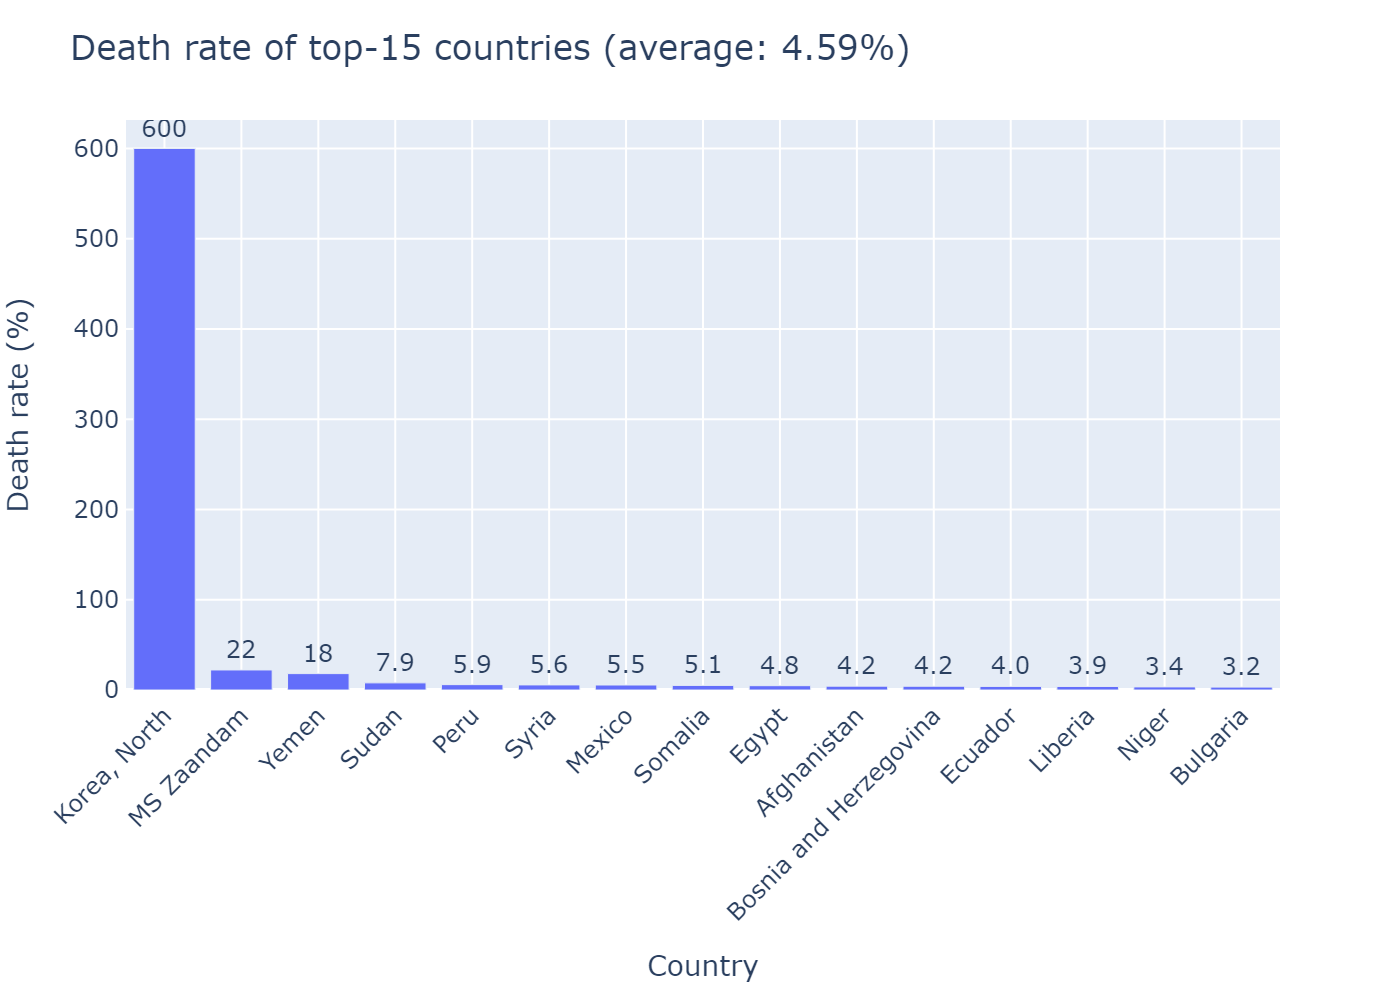

In [43]:
# Now let's see the top countries
ave_death_rate = global_death_rate_collapse_country[date_string[-1]].mean()
top_country = global_death_rate_collapse_country.nlargest(15, date_string[-1])

# Bar chart
fig = px.bar(top_country, y=date_string[-1], x='Country', text=date_string[-1])

margin_size = 60
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', 
                  title_text = "Death rate of top-15 countries (average: " + str(round(ave_death_rate,2)) + "%)")
fig.update_yaxes(title_text="Death rate (%)")
fig.update_xaxes(title_text="Country", tickangle=-45)

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

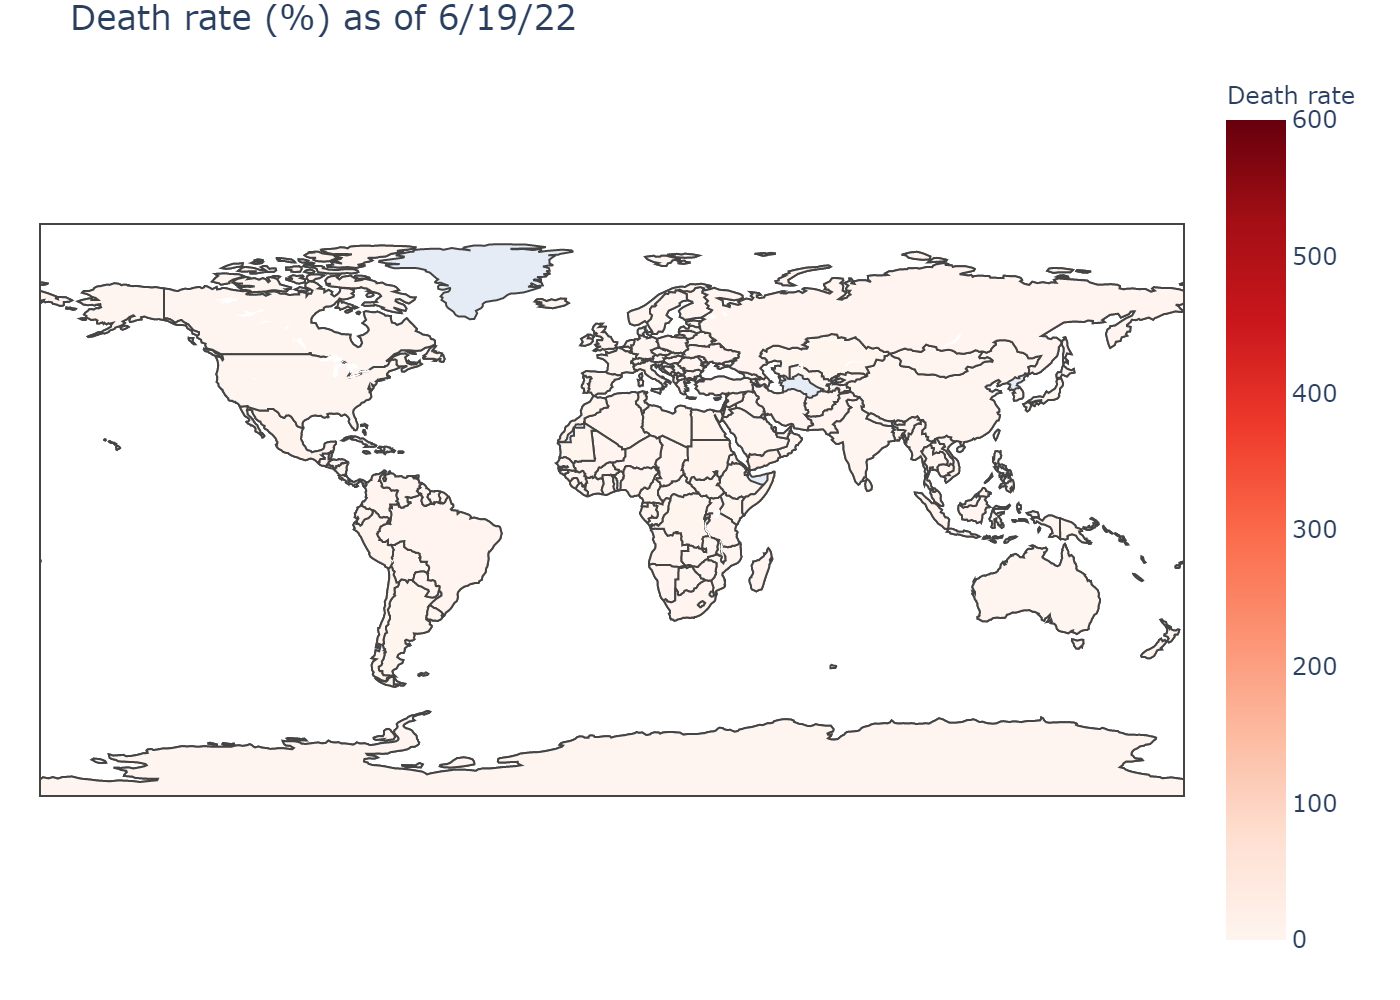

In [44]:
# Now let's see the world map
fig = go.Figure(data=go.Choropleth(
    locations=global_death_rate_collapse_country["Country"], # Country names
    locationmode = 'country names', # set the mode to country name
    z = global_death_rate_collapse_country[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "Death rate",
))

fig.update_layout(
    title_text = 'Death rate (%) as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Create a new table to merge GDP, population and death tables

In [45]:
# Make new table with # deaths, death rate, GDP and population
table_death_GDP_pop = global_death_collapse_country.merge(GDP[['Country_GDP', 'GDP']], left_on='Country', right_on='Country_GDP', how='inner')
table_death_GDP_pop = table_death_GDP_pop.merge(population[['Country_Population', 'Population']], left_on='Country', right_on='Country_Population', how='inner')
global_death_rate_collapse_country.rename(columns = {'Country': 'Country_death_rate',
                                                    date_string[-1]: 'Death_rate'}, inplace=True)
table_death_GDP_pop = table_death_GDP_pop.merge(global_death_rate_collapse_country.iloc[:, [0, -1]], left_on='Country', right_on='Country_death_rate', how='inner')

# Drop the redundant columns
table_death_GDP_pop.drop(columns=['Country_Population', 'Country_GDP', 'Country_death_rate'], inplace=True)


In [46]:
table_death_GDP_pop.head(2)

Country       Lat       Long  1/22/20  1/23/20  1/24/20  1/25/20  \
0  Afghanistan  33.93911  67.709953        0        0        0        0   
1      Albania  41.15330  20.168300        0        0        0        0   

   1/26/20  1/27/20  1/28/20  ...  6/13/22  6/14/22  6/15/22  6/16/22  \
0        0        0        0  ...     7710     7710     7710     7713   
1        0        0        0  ...     3497     3497     3497     3497   

   6/17/22  6/18/22  6/19/22           GDP  Population  Death_rate  
0     7713     7713     7713  1.936297e+10  37172386.0    4.245704  
1     3497     3497     3497  1.510250e+10   2866376.0    1.260594  

[2 rows x 886 columns]

## Relation between COVID-19 death and GDP/Population

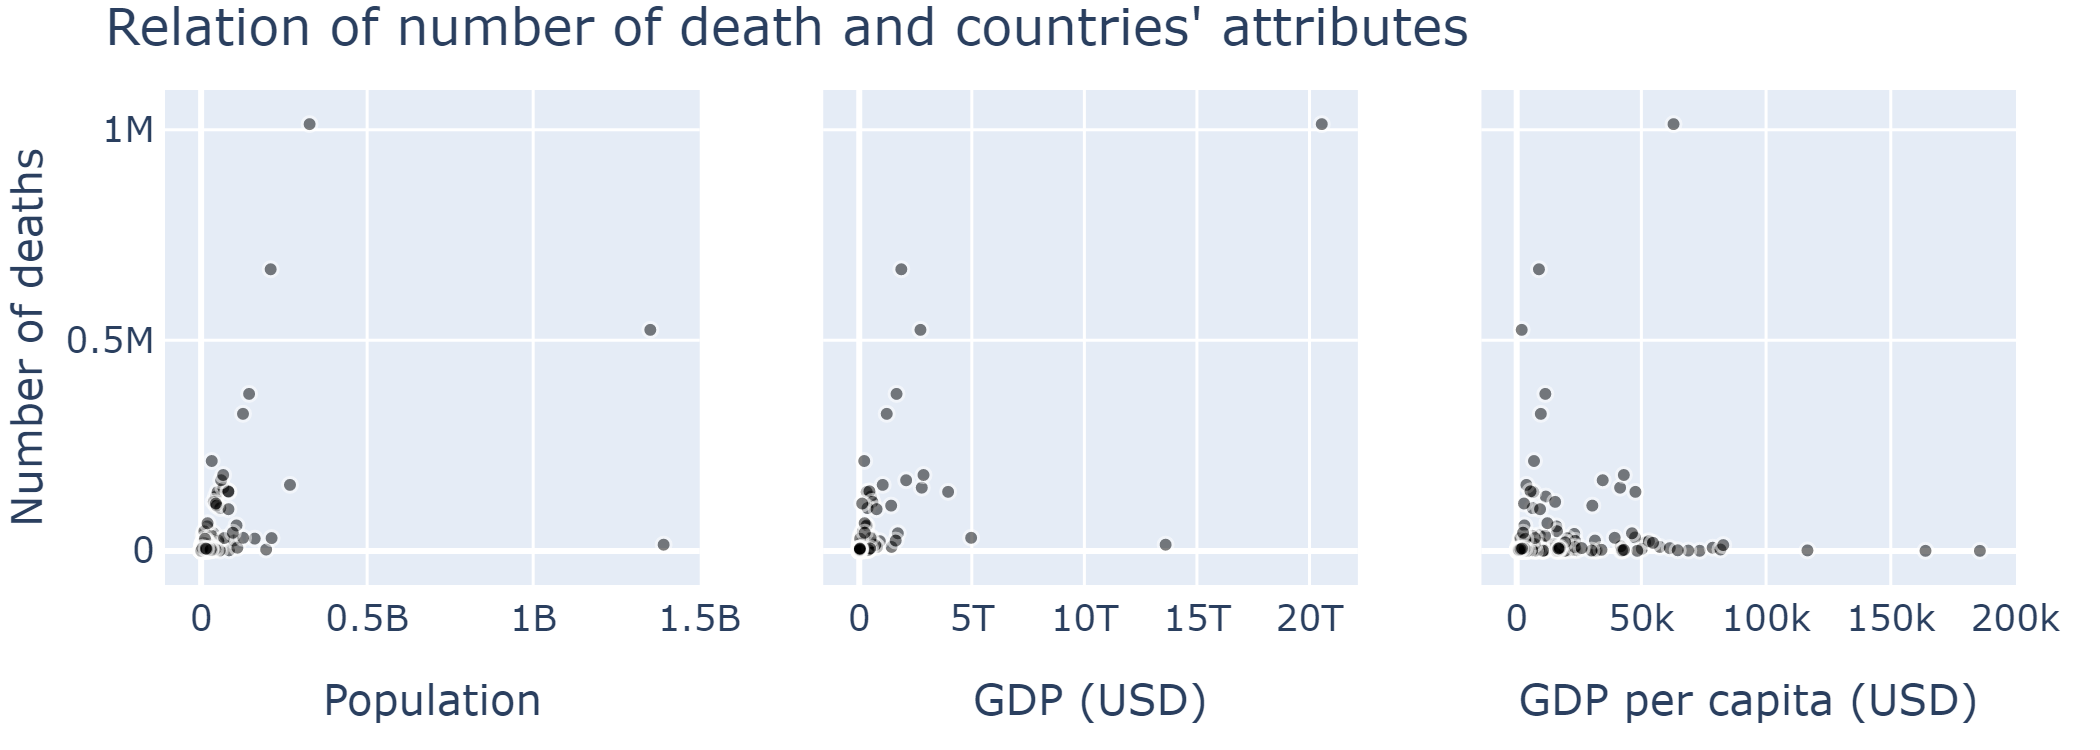

In [47]:
# Look at number of deaths
matrix_num_case = table_death_GDP_pop.drop(table_death_GDP_pop.iloc[:, :-4], axis=1).to_numpy()
gdp_per_captia = matrix_num_case[:, -3] / matrix_num_case[:, -2]
country_COVID_GDP_pop = list(table_death_GDP_pop['Country'])

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -2], y=matrix_num_case[:, -4], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_GDP_pop),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -3], y=matrix_num_case[:, -4], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=2)              
fig.add_trace(go.Scatter(x=gdp_per_captia, y=matrix_num_case[:, -4], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=3)  

fig.update_yaxes(title_text="Number of deaths", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Population", row=1, col=1)
fig.update_xaxes(title_text="GDP (USD)", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita (USD)", row=1, col=3)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of number of death and countries' attributes")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

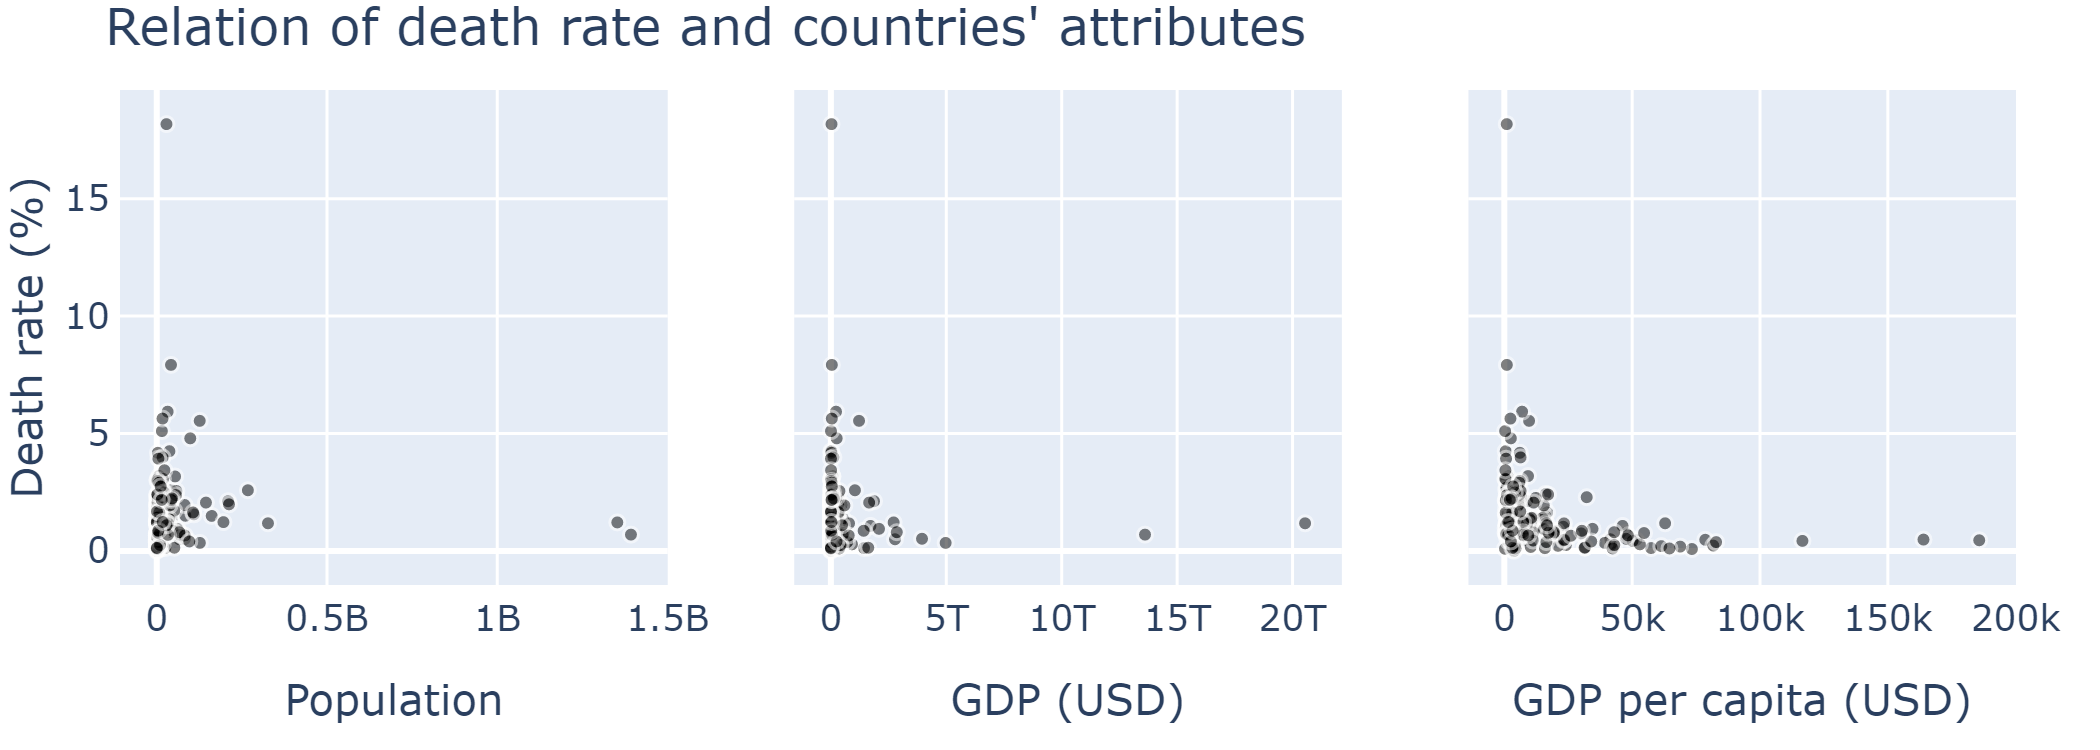

In [48]:
# Look at death rate
country_COVID_GDP_pop = list(table_death_GDP_pop['Country'])

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -2], y=matrix_num_case[:, -1], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_GDP_pop),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -3], y=matrix_num_case[:, -1], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=2)              
fig.add_trace(go.Scatter(x=gdp_per_captia, y=matrix_num_case[:, -1], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_GDP_pop),                         
              row=1, col=3)  

fig.update_yaxes(title_text="Death rate (%)", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Population", row=1, col=1)
fig.update_xaxes(title_text="GDP (USD)", row=1, col=2)
fig.update_xaxes(title_text="GDP per capita (USD)", row=1, col=3)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of death rate and countries' attributes")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

### The results are somewhat similar to number of confirmed cases. The number of death is most correlated with GDP while death rate is most correlated with GDP per capita

# Import more data on healthcare spending 
The whole dataset (and more others) can be downloaded from WHO website: https://apps.who.int/nha/database/Select/Indicators/en

Here I just consider a small subset of the whole dataset, that is the total healthcare spending and spending percapita.

In [49]:
# Load data
print('Beginning data loading ...')

# Data directory
dir_data = os.path.join(os.getcwd(), 'data')

# Get the data
dir_healthcare = os.path.join(dir_data, 'Healthcare_spending.csv')
health_spending = pd.read_csv(dir_healthcare, engine='python')
    
print('Data loading finished!')

Beginning data loading ...
Data loading finished!


In [50]:
# Change the scale and name of total spending column
health_spending['Total_Million_US'] = 1000000 * health_spending['Total_Million_US'] 
health_spending.rename(columns = {'Total_Million_US': 'Total_US'}, inplace=True)

### Another noteworthy point is that for each country and each year, there are several sources of health care spending (out-of-pocket, insurance, etc.), which is in the column "Indicator Name". Here I just take the highest among all sources.

In [51]:
# Collapse across country (take the latest data point)
health_spending_collapse = health_spending.sort_values(['Year', 'Total_US'], ascending=False).drop_duplicates('Country Name', keep='first')
health_spending_collapse.head(2)

Country Name  \
737   United States of America   
2991                     China   

                                       Indicator Name  Year      Total_US  \
737   Current health expenditure by financing schemes  2017  3.324457e+12   
2991  Current health expenditure by financing schemes  2017  6.213514e+11   

      Per_capita_US  
737    10246.138210  
2991     440.825633

## Cleaning the data
Similar to GPD/Population data, I also have to find the countries name that don't match and manually correct it if possible.

In [52]:
# List of the same non-match countries
replace_old = ['The Republic of North Macedonia',
              'United States of America',
              'Republic of Korea',
              'Brunei Darussalam',
              "Lao People's Democratic Republic",
              'Czech Republic',
              'United Republic of Tanzania',
              'Cabo Verde Republic of',
              "C“te d'Ivoire",
              'Democratic Republic of the Congo',
              'Republic of Moldova',
              'Russian Federation',
              'Bolivia Plurinational States of ',
              'Congo',
              'Venezuela (Bolivarian Republic of)',
              'Myanmar',
              'Viet Nam']

replace_new = ['North Macedonia',
              'US',
              'Korea, South',
              'Brunei',
              'Laos',
              'Czechia',
              'Tanzania',
              'Cabo Verde',
              "Cote d'Ivoire",
              'Congo (Kinshasa)',
              'Moldova',
              'Russia',
              'Bolivia',
              'Congo (Brazzaville)',
              'Venezuela',
              'Burma',
              'Vietnam']

# Replace the name to match COVID-19 data
health_spending_collapse.replace(replace_old, replace_new, inplace=True)

In [53]:
# Select only countries that match COVID-19 data
health_spending_collapse = health_spending_collapse[health_spending_collapse['Country Name'].isin(country_COVID)]

## Check the cleaned data

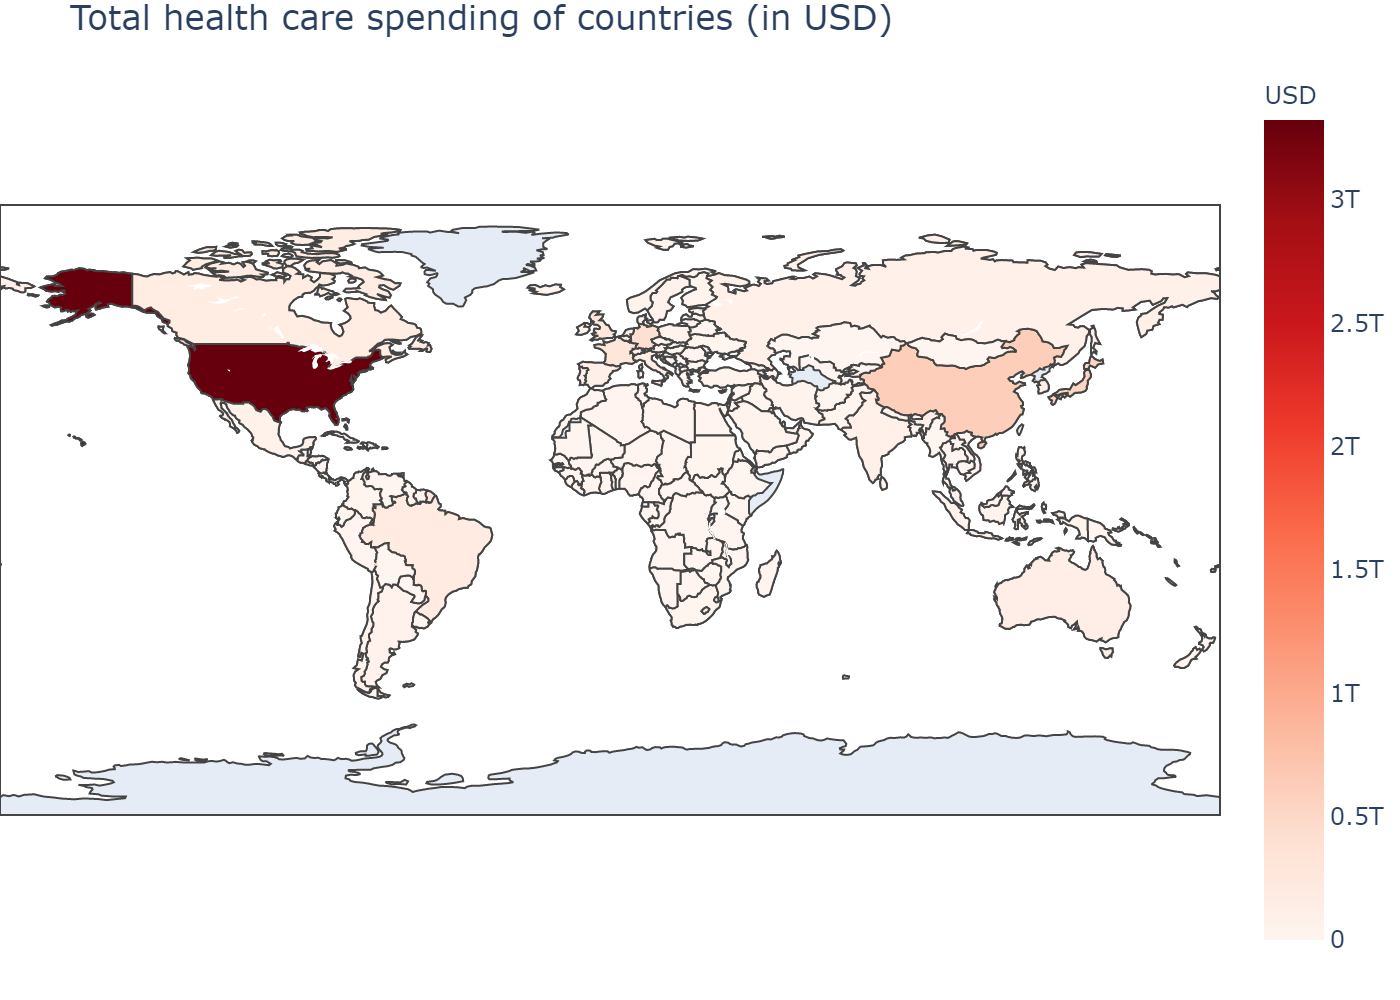

In [54]:
# First plot total spending
fig = go.Figure(data=go.Choropleth(
    locations=health_spending_collapse["Country Name"], # Country names
    locationmode = 'country names', # set the mode to "country names"
    z = health_spending_collapse["Total_US"].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "USD",
))

fig.update_layout(
    title_text = 'Total health care spending of countries (in USD)',
    margin=dict(l=0, r=0, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

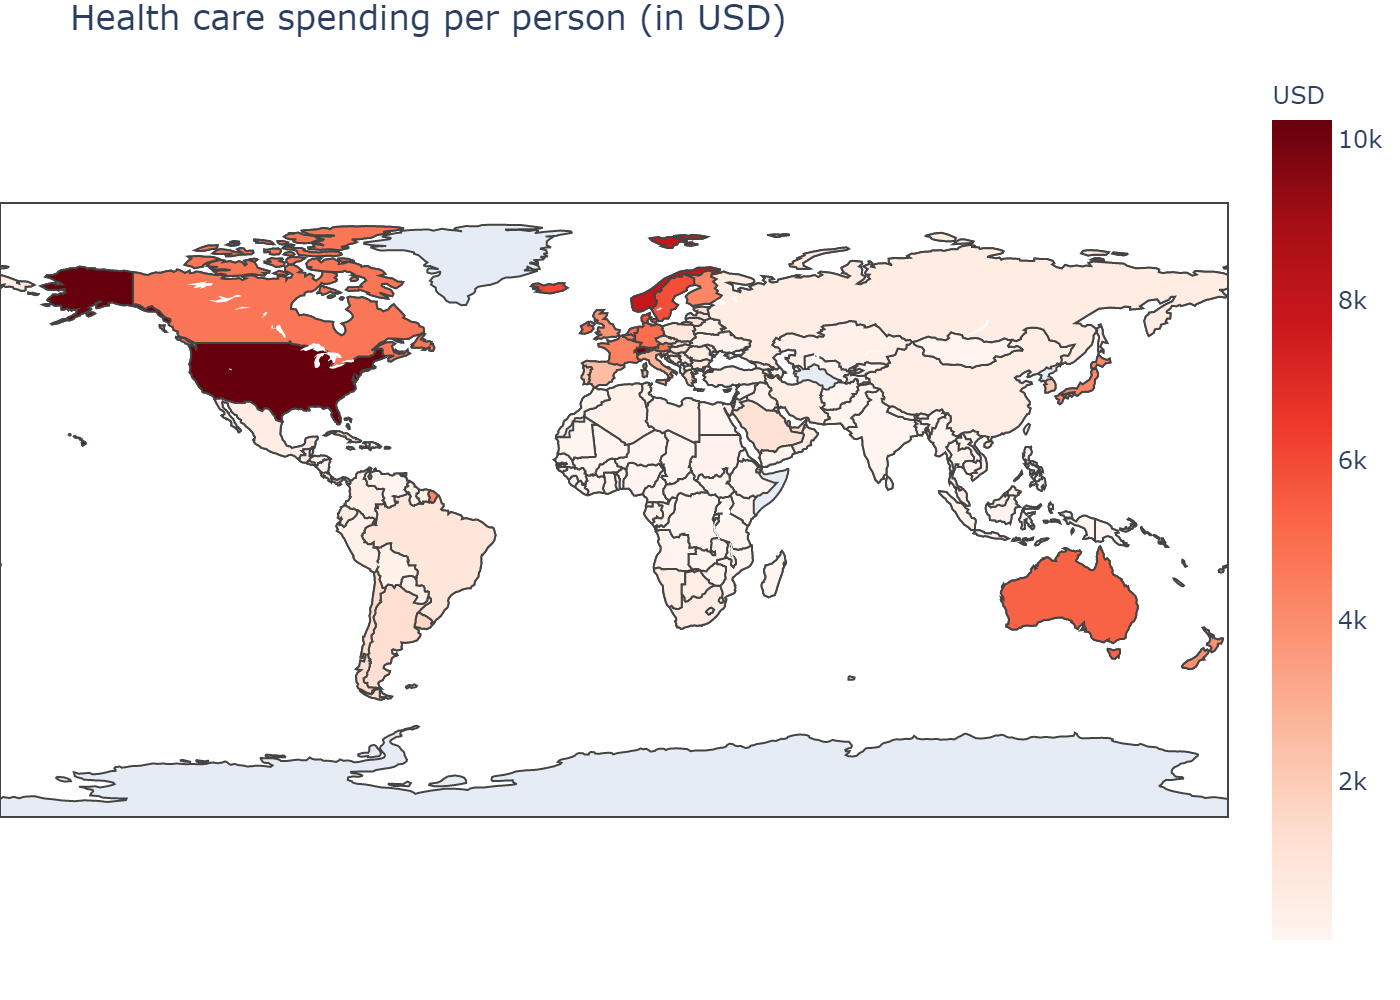

In [55]:
# Now check spending per capita
fig = go.Figure(data=go.Choropleth(
    locations=health_spending_collapse["Country Name"], # Country names
    locationmode = 'country names', # set the mode to "country names"
    z = health_spending_collapse["Per_capita_US"].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "USD",
))

fig.update_layout(
    title_text = 'Health care spending per person (in USD)',
    margin=dict(l=0, r=0, t=30, b=20)
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Combine healthcare and death tables

In [56]:
# Take a look at some countries in COVID data but are not in healthcare data
country_missed = []
country_health = list(health_spending_collapse['Country Name'])
for country in country_COVID:
    if country not in country_health:
        country_missed.append(country)
        
print("Countries missed in healthcare data: ", country_missed)

Countries missed in healthcare data:  ['Antarctica', 'Diamond Princess', 'Holy See', 'Korea, North', 'Kosovo', 'Liechtenstein', 'MS Zaandam', 'Micronesia', 'Montenegro', 'Somalia', 'Summer Olympics 2020', 'Taiwan*', 'West Bank and Gaza', 'Winter Olympics 2022']


In [57]:
# Merge the tables
table_health_death = health_spending_collapse.merge(global_death_collapse_country[["Country", date_string[-1]]], left_on='Country Name', 
                                                    right_on='Country', how='inner')
table_health_death = table_health_death.merge(global_death_rate_collapse_country[['Country_death_rate', 'Death_rate']], left_on='Country Name', 
                                                  right_on='Country_death_rate', how='inner')

In [58]:
# Drop redudant columns
table_health_death.drop(columns=['Indicator Name', 'Country', 'Country_death_rate'], inplace=True)

# Rename # death column
table_health_death.rename(columns={date_string[-1]: 'Num_death'}, inplace=True)

In [59]:
table_health_death.head(2)

Country Name  Year      Total_US  Per_capita_US  Num_death  Death_rate
0           US  2017  3.324457e+12   10246.138210    1013413    1.175025
1        China  2017  6.213514e+11     440.825633      14621    0.691586

## Relation between COVID-19 death and health spending

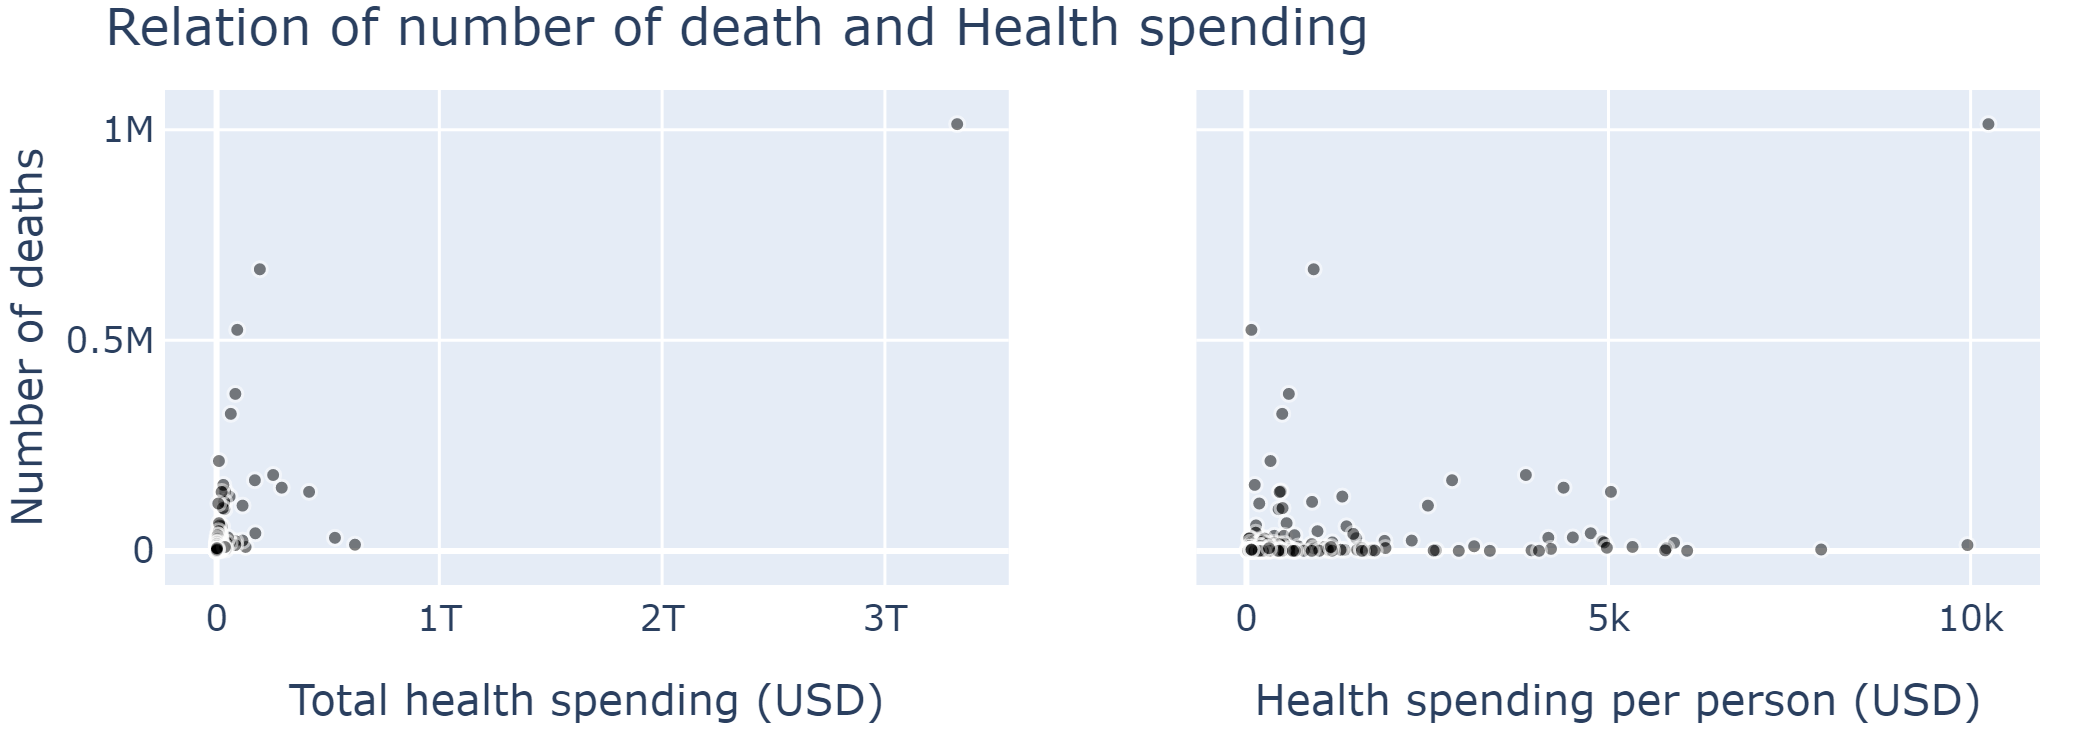

In [60]:
# Look at number of deaths
matrix_num_case = table_health_death.drop(table_health_death.columns[[0, 1]], axis=1).to_numpy()
country_COVID_health = list(table_health_death['Country Name'])

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -4], y=matrix_num_case[:, -2], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_health),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -3], y=matrix_num_case[:, -2], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_health),                         
              row=1, col=2)              


fig.update_yaxes(title_text="Number of deaths", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Total health spending (USD)", row=1, col=1)
fig.update_xaxes(title_text="Health spending per person (USD)", row=1, col=2)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of number of death and Health spending")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

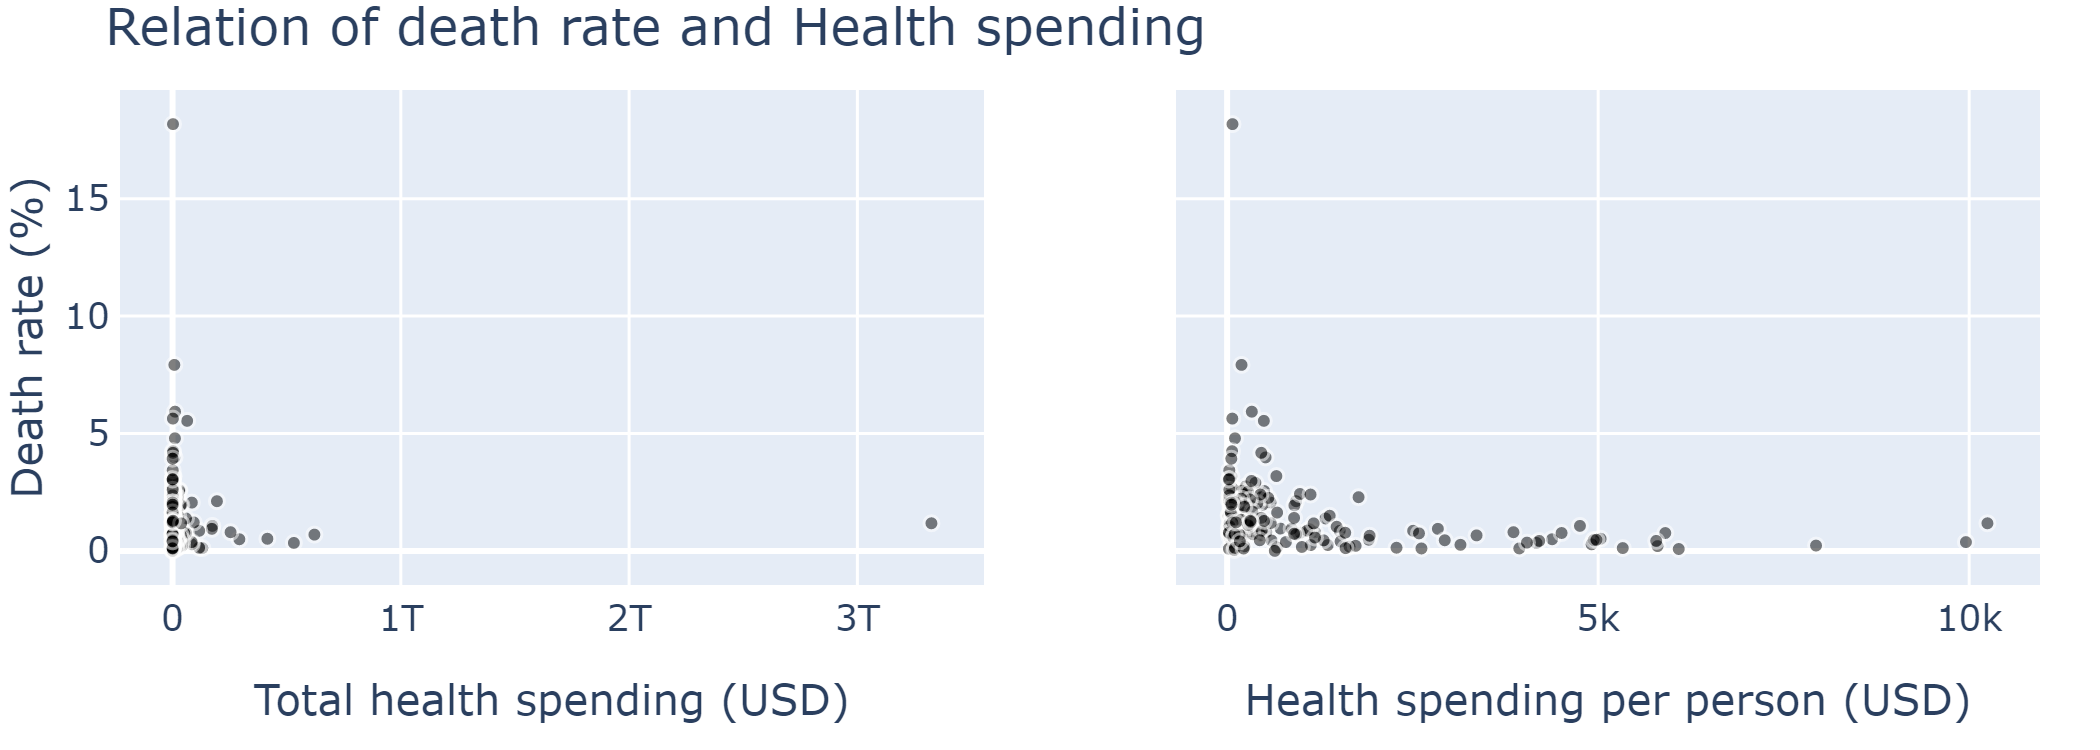

In [61]:
# Look at death rate
country_COVID_health = list(table_health_death['Country Name'])

# Plot the number of cases
fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=(), shared_yaxes=True)

fig.add_trace(go.Scatter(x=matrix_num_case[:, -4], y=matrix_num_case[:, -1], mode='markers', 
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)), 
              hovertext=country_COVID_health),
              row=1, col=1)
fig.add_trace(go.Scatter(x=matrix_num_case[:, -3], y=matrix_num_case[:, -1], mode='markers',
              marker=dict(color='Black', size=5, opacity=0.5, line=dict(color='White', width=1)),
              hovertext=country_COVID_health),                         
              row=1, col=2)              


fig.update_yaxes(title_text="Death rate (%)", title_standoff = 0, row=1, col=1)
fig.update_xaxes(title_text="Total health spending (USD)", row=1, col=1)
fig.update_xaxes(title_text="Health spending per person (USD)", row=1, col=2)
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), height=250, showlegend=False, 
                  title_text="Relation of death rate and Health spending")

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=3))

### It is interesting that there's no relationship between death rate and health spending per person. It could be that for this infectious disease, the investment in health care does not help. Alternatively, it could be that the investment in health care is not that efficient (like in the US). 